In [135]:
# Import dependencies
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
%matplotlib inline
from scipy.stats import norm
import statsmodels.api as sm
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Importing Dependencies for DB connection
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
from config import config
import psycopg2

Exception during reset or similar
Traceback (most recent call last):
  File "/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 670, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 875, in _reset
    pool._dialect.do_rollback(self)
  File "/Users/oi/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sqlalchemy/engine/default.py", line 642, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



In [136]:
# Establish a connection to the database
conn = psycopg2.connect(
    host = config['host'],
    port = config['port'], 
    dbname = config['dbname'], 
    user = config['user'], 
    password = config['password'])

print("Postgres Connected")

Postgres Connected


In [137]:
# Import Data from AWS database
data= pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)
data1 = pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)
data

,idML,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
0,408280,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60505.0,
1,408283,2015-01-01,Quebec,101,"Total, all occupations",Full-time,45385.0,
2,653248,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14230.0,
3,653251,2015-01-01,Saskatchewan,101,"Total, all occupations",Full-time,10375.0,
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,
...,...,...,...,...,...,...,...,...
7225,27254351,2021-04-01,Nunavut,101,"Total, all occupations",Full-time,515.0,
7226,27263181,2021-04-01,Nunavut,1,"Business, finance and administration occupations","Type of work, all types",75.0,
7227,27263184,2021-04-01,Nunavut,1,"Business, finance and administration occupations",Full-time,70.0,
7228,27309524,2021-04-01,Nunavut,7,"Trades, transport and equipment operators and ...","Type of work, all types",160.0,


In [138]:
#exporting data to csv for province level impute
# data.to_csv('data.csv')

In [139]:
# slicing for 'Canada'
ts_data= data
ts_data= data.loc[data['geo']=='Canada',:]

ts_data.head()

,idML,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,
5,1143187,2015-04-01,Canada,101,"Total, all occupations",Full-time,322450.0,
6,1143190,2015-04-01,Canada,101,"Total, all occupations",Part-time,129475.0,
7,1143302,2015-04-01,Canada,0,Management occupations,"Type of work, all types",24100.0,
8,1143305,2015-04-01,Canada,0,Management occupations,Full-time,23030.0,


In [140]:
# slicing for 'Total, all occupations' in NOC
ts_data= ts_data.loc[ts_data['noc_desc']=='Total, all occupations',:]
ts_data.head()

,idML,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,
5,1143187,2015-04-01,Canada,101,"Total, all occupations",Full-time,322450.0,
6,1143190,2015-04-01,Canada,101,"Total, all occupations",Part-time,129475.0,
301,2286368,2015-07-01,Canada,101,"Total, all occupations","Type of work, all types",407865.0,
302,2286371,2015-07-01,Canada,101,"Total, all occupations",Full-time,270305.0,


In [141]:
# slicing for 'Total, all occupations' in job_char
ts_data= ts_data.loc[ts_data['job_char']=='Type of work, all types',:]

ts_data.head()

,idML,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,
301,2286368,2015-07-01,Canada,101,"Total, all occupations","Type of work, all types",407865.0,
606,3429552,2015-10-01,Canada,101,"Total, all occupations","Type of work, all types",358755.0,
903,4572736,2016-01-01,Canada,101,"Total, all occupations","Type of work, all types",330215.0,
1203,5715920,2016-04-01,Canada,101,"Total, all occupations","Type of work, all types",391190.0,


In [142]:
df= ts_data
df

,idML,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,
301,2286368,2015-07-01,Canada,101,"Total, all occupations","Type of work, all types",407865.0,
606,3429552,2015-10-01,Canada,101,"Total, all occupations","Type of work, all types",358755.0,
903,4572736,2016-01-01,Canada,101,"Total, all occupations","Type of work, all types",330215.0,
1203,5715920,2016-04-01,Canada,101,"Total, all occupations","Type of work, all types",391190.0,
1525,6859104,2016-07-01,Canada,101,"Total, all occupations","Type of work, all types",404860.0,
1838,8002288,2016-10-01,Canada,101,"Total, all occupations","Type of work, all types",381010.0,
2151,9145472,2017-01-01,Canada,101,"Total, all occupations","Type of work, all types",387080.0,
2463,10288656,2017-04-01,Canada,101,"Total, all occupations","Type of work, all types",459685.0,
2785,11431840,2017-07-01,Canada,101,"Total, all occupations","Type of work, all types",467395.0,


In [143]:
# remove unnecessary columns
df=df.loc[:, ['ref_date','total_vacancies']]
df

,ref_date,total_vacancies
4,2015-04-01,451925.0
301,2015-07-01,407865.0
606,2015-10-01,358755.0
903,2016-01-01,330215.0
1203,2016-04-01,391190.0
1525,2016-07-01,404860.0
1838,2016-10-01,381010.0
2151,2017-01-01,387080.0
2463,2017-04-01,459685.0
2785,2017-07-01,467395.0


In [144]:
df.shape

(23, 2)

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 4 to 6920
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ref_date         23 non-null     object 
 1   total_vacancies  23 non-null     float64
dtypes: float64(1), object(1)
memory usage: 552.0+ bytes


In [146]:
# impute missing data for Q2 & Q3 2020

missing_data = pd.DataFrame({'ref_date': ['2020-04-01','2020-07-01'],
                    'total_vacancies' : [544151.77,531932.19]})

df = pd.concat([df, missing_data], ignore_index = True, axis = 0)

df.tail()

,ref_date,total_vacancies
20,2020-10-01,560215.00
21,2021-01-01,553480.00
22,2021-04-01,731905.00
23,2020-04-01,544151.77
24,2020-07-01,531932.19


In [147]:
df.shape

(25, 2)

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ref_date         25 non-null     object 
 1   total_vacancies  25 non-null     float64
dtypes: float64(1), object(1)
memory usage: 528.0+ bytes


In [149]:
#  convert the REF_DATE column into a datetime object
df['ref_date'] = pd.to_datetime(df['ref_date'], format='%Y-%m')

In [150]:
df.sort_values(by='ref_date', ascending=True, inplace=True)
df.tail()

,ref_date,total_vacancies
23,2020-04-01,544151.77
24,2020-07-01,531932.19
20,2020-10-01,560215.00
21,2021-01-01,553480.00
22,2021-04-01,731905.00


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 22
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ref_date         25 non-null     datetime64[ns]
 1   total_vacancies  25 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 600.0 bytes


In [152]:
df.set_index('ref_date', inplace=True)
print(df.shape)

(25, 1)


In [153]:
df

,total_vacancies
ref_date,
2015-04-01,451925.00
2015-07-01,407865.00
2015-10-01,358755.00
2016-01-01,330215.00
2016-04-01,391190.00
2016-07-01,404860.00
2016-10-01,381010.00
2017-01-01,387080.00
2017-04-01,459685.00


## Time series Analysis 

In [154]:
#visualize the time series data

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

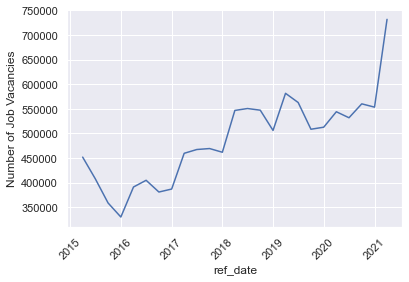

In [155]:
sns.lineplot(data= df, x='ref_date', y= 'total_vacancies')
plt.ylabel('Number of Job Vacancies')
plt.xticks(rotation=45)

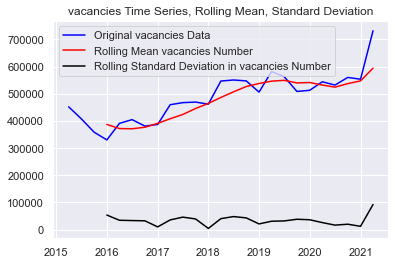

In [156]:
'''check for stationary
A stationary time series will not have any trends or seasonal patterns
We will use the Dickey Fuller test to check for stationarity in our data '''

rolling_mean = df.rolling(4).mean()
rolling_std = df.rolling(4).std()

#First, let’s make a Matplotlib plot of our time series
plt.plot(df, color="blue",label="Original vacancies Data")
# then the rolling mean
plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
#And finally, the rolling standard deviation:
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
#Let’s then add a title:
plt.title("vacancies Time Series, Rolling Mean, Standard Deviation")
#And a legend:
plt.legend(loc="best")

In [157]:
#We will use the Dickey Fuller test to check for stationarity in our data
from statsmodels.tsa.stattools import adfuller
df_test=df.iloc[:,0].values
adft = adfuller(df_test,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0   2.347944              Test Statistics
1   0.998984                      p-value
2   7.000000             No. of lags used
3  17.000000  Number of observations used
4  -3.889266          critical value (1%)
5  -3.054358          critical value (5%)
6  -2.666984         critical value (10%)


our data is not stationary as p value is higher than 0.05

In [158]:
# Checking for autocorrelation in time series data
# This is a measure of how correlated time series data is at a given point in time with past values
autocorrelation_lag1 = df['total_vacancies'].autocorr(lag=1)
print("One Quarter Lag: ", autocorrelation_lag1)

autocorrelation_lag2 = df['total_vacancies'].autocorr(lag=2)
print("Two Quaretrs Lag: ", autocorrelation_lag2)

autocorrelation_lag3 = df['total_vacancies'].autocorr(lag=3)
print("Three Quaretrs Lag: ", autocorrelation_lag3)

autocorrelation_lag4 = df['total_vacancies'].autocorr(lag=4)
print("Four Quaretrs Lag: ", autocorrelation_lag4)

One Quarter Lag:  0.8145162959523271
Two Quaretrs Lag:  0.7294501466461943
Three Quaretrs Lag:  0.6854108793355617
Four Quaretrs Lag:  0.7399548793483851


the data is autocorrelated

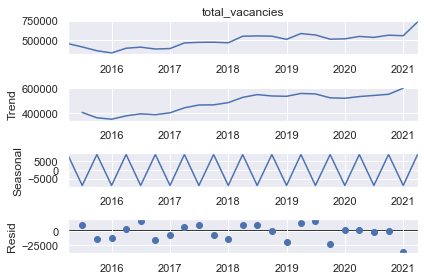

In [159]:
#Check for Trend decomposition is another useful way to visualize the trends in time series data
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['total_vacancies'],model='additive', period=2)
decompose.plot()
plt.show()

From this plot, we can clearly see the increasing trend in number of vacancies and the seasonality patterns in the rise and fall in values each year.

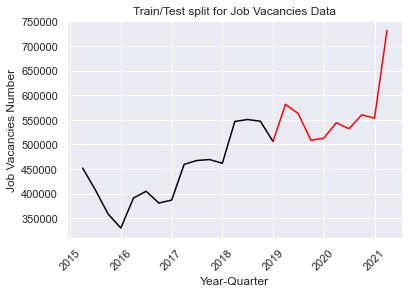

In [160]:
# Forescasting
df['ref_date']=df.index
train = df[df['ref_date'] < "2019-04-01"]
train['train'] = train['total_vacancies']
del train['ref_date']
del train['total_vacancies']

test = df[df['ref_date'] >= "2019-04-01"]
del test['ref_date']
test['test'] = test['total_vacancies']
del test['total_vacancies']

plt.plot(train, color = "black")
plt.plot(pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test]), color = "red")
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
sns.set()
plt.show()

In [161]:
# code to connect train and split data for the plot above
pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test])

,test
ref_date,
2019-01-01,506140.00
2019-04-01,581595.00
2019-07-01,562910.00
2019-10-01,508590.00
2020-01-01,512760.00
2020-04-01,544151.77
2020-07-01,531932.19
2020-10-01,560215.00
2021-01-01,553480.00


## SARIMAX

source: https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

In [162]:
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

## Re-trian SARIMAX model with all data available

In [163]:
# Dataset
data = df
data.index = data.ref_date
# Set the frequency
data.index.freq="QS-OCT"

# Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
mod = sm.tsa.statespace.SARIMAX(train, trend='t', order=(1,0,1),seasonal_order=(1, 1, 1, 2))
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             train   No. Observations:                   16
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 2)   Log Likelihood                -173.870
Date:                           Wed, 01 Dec 2021   AIC                            359.740
Time:                                   20:20:24   BIC                            363.574
Sample:                               04-01-2015   HQIC                           359.385
                                    - 01-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -977.0803      0.000  -2.48e+06      0.000    -977.081    -977.080
ar.L1         -0.6915      0.078     -8.810

In [164]:
# forecast values for test data
forecast = res.predict(test.index[0],test.index[-1], dynamic=True)
forecast = pd.DataFrame(forecast.values,index = test.index,columns=['predicted_vacancies'])
forecast.head()

,predicted_vacancies
ref_date,
2019-04-01,587114.145616
2019-07-01,549742.270902
2019-10-01,535891.166336
2020-01-01,495490.279135
2020-04-01,574935.760176


In [165]:
# create dataframe for results
output = test.merge(forecast, how='inner', left_index=True, right_index=True)
output.head()

,test,predicted_vacancies
ref_date,,
2019-04-01,581595.00,587114.145616
2019-07-01,562910.00,549742.270902
2019-10-01,508590.00,535891.166336
2020-01-01,512760.00,495490.279135
2020-04-01,544151.77,574935.760176


In [166]:
#Evaluating SARIMA model

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,explained_variance_score,r2_score

evs = explained_variance_score(output.test,output.predicted_vacancies,multioutput='uniform_average')
print(f'Explained Variance Score : {evs}')
mse = mean_squared_error(output.test,output.predicted_vacancies, squared=False)
print(f'Mean Square Error : {mse}')
mape = mean_absolute_percentage_error(output.test,output.predicted_vacancies, multioutput='uniform_average')
print(f'Mean Absolute Percentage Error : {mape}')
rsqr =r2_score(output.test,output.predicted_vacancies,multioutput='uniform_average')
print(f'Coefficient of determination Training (R^2) : {rsqr}')

Explained Variance Score : 0.11669446439130693
Mean Square Error : 64996.799948844025
Mean Absolute Percentage Error : 0.06857964273818341
Coefficient of determination Training (R^2) : -0.06409222874115805


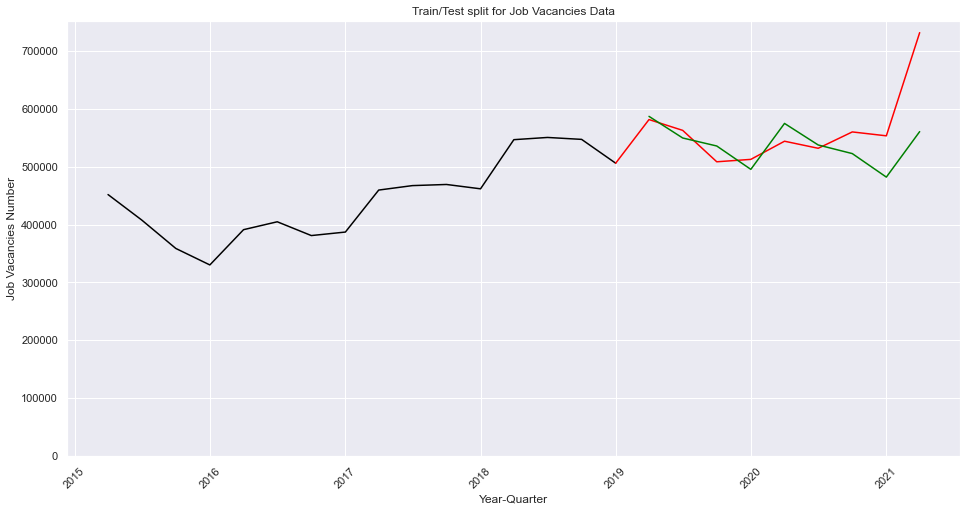

In [167]:
#visualize results
plt.plot(train, color = "black")
plt.plot(pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test]), color = "red")
plt.plot(forecast['predicted_vacancies'],color= 'green')
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
plt.ylim(ymin=0)
sns.set()
plt.show()

In [168]:
# rename columns to prepare for later append
output.columns=['total_vacancies','predicted_vacancies']
output.head()

,total_vacancies,predicted_vacancies
ref_date,,
2019-04-01,581595.00,587114.145616
2019-07-01,562910.00,549742.270902
2019-10-01,508590.00,535891.166336
2020-01-01,512760.00,495490.279135
2020-04-01,544151.77,574935.760176


In [169]:
# check model accuaracy with actual values from statCan
Actual=[560215,553480,731905]
predict_quarters=['2020-10-01','2021-01-01','2021-04-01']

forecast_data=[]
counter=0
for i in predict_quarters:
    forecast_test = res.predict(i)
    forecast_data.append(forecast_test)
    counter +=1
    
forecast_data

[2020-10-01    522764.864599
 Freq: QS-OCT, dtype: float64,
 2021-01-01    482099.040854
 Freq: QS-OCT, dtype: float64,
 2021-04-01    560744.7615
 Freq: QS-OCT, dtype: float64]

In [170]:
forecast_data[2].index # list of dataframes

DatetimeIndex(['2021-04-01'], dtype='datetime64[ns]', freq='QS-OCT')

In [171]:
#keep only forecast numbers
[int(f.values[0]) for f in forecast_data]

[522764, 482099, 560744]

In [172]:
# create results dataframe
forecast_df= pd.DataFrame({'Predicted Value':[int(f.values[0]) for f in forecast_data], 'Actual Value': Actual}, index=predict_quarters)
forecast_df.head()

,Predicted Value,Actual Value
2020-10-01,522764,560215
2021-01-01,482099,553480
2021-04-01,560744,731905


In [173]:
# generate predictions from Q2 2021-Q2 2025 for DB
actual_all = ['','',\
             '','','','',\
              '','','','',\
              '','','','',\
              '','','','']
future_predictions= ['2021-07-01','2021-10-01',\
                     '2022-01-01','2022-04-01','2022-07-01','2022-10-01',\
                     '2023-01-01','2023-04-01','2023-07-01','2023-10-01',\
                    '2024-01-01','2024-04-01','2024-07-01','2024-10-01',\
                     '2025-01-01','2025-04-01','2025-07-01','2025-10-01']

forecast_all=[]

counter=0
for i in future_predictions:
    forecasts = res.predict(i)
    forecast_all.append(forecasts)
    counter +=1
    
forecast_all

[2021-07-01    523020.126198
 Freq: QS-OCT, dtype: float64,
 2021-10-01    507470.461059
 Freq: QS-OCT, dtype: float64,
 2022-01-01    466298.656292
 Freq: QS-OCT, dtype: float64,
 2022-04-01    544311.306021
 Freq: QS-OCT, dtype: float64,
 2022-07-01    506042.9926
 Freq: QS-OCT, dtype: float64,
 2022-10-01    489898.042362
 Freq: QS-OCT, dtype: float64,
 2023-01-01    448165.133484
 Freq: QS-OCT, dtype: float64,
 2023-04-01    525582.832143
 Freq: QS-OCT, dtype: float64,
 2023-07-01    486744.480261
 Freq: QS-OCT, dtype: float64,
 2023-10-01    470022.47306
 Freq: QS-OCT, dtype: float64,
 2024-01-01    427715.854269
 Freq: QS-OCT, dtype: float64,
 2024-04-01    504547.319856
 Freq: QS-OCT, dtype: float64,
 2024-07-01    465132.901339
 Freq: QS-OCT, dtype: float64,
 2024-10-01    447838.005071
 Freq: QS-OCT, dtype: float64,
 2025-01-01    404954.793599
 Freq: QS-OCT, dtype: float64,
 2025-04-01    481202.020375
 Freq: QS-OCT, dtype: float64,
 2025-07-01    441210.156695
 Freq: QS-OCT,

In [174]:
#keep only forecast numbers
[int(f.values[0]) for f in forecast_all]

[523020,
 507470,
 466298,
 544311,
 506042,
 489898,
 448165,
 525582,
 486744,
 470022,
 427715,
 504547,
 465132,
 447838,
 404954,
 481202,
 441210,
 423343]

In [175]:
# create results dataframe
forecast_all_df= pd.DataFrame({'predicted_vacancies':[int(f.values[0]) for f in forecast_all], 'total_vacancies': actual_all}, index=future_predictions)
forecast_all_df= pd.DataFrame(forecast_all_df,columns=['total_vacancies','predicted_vacancies'])
forecast_all_df.head()                      

,total_vacancies,predicted_vacancies
2021-07-01,,523020
2021-10-01,,507470
2022-01-01,,466298
2022-04-01,,544311
2022-07-01,,506042


In [176]:
#create model output
model_output = output.append(forecast_all_df)
model_output

,total_vacancies,predicted_vacancies
2019-04-01 00:00:00,581595.0,587114.145616
2019-07-01 00:00:00,562910.0,549742.270902
2019-10-01 00:00:00,508590.0,535891.166336
2020-01-01 00:00:00,512760.0,495490.279135
2020-04-01 00:00:00,544151.77,574935.760176
2020-07-01 00:00:00,531932.19,537639.533298
2020-10-01 00:00:00,560215.0,522764.864599
2021-01-01 00:00:00,553480.0,482099.040854
2021-04-01 00:00:00,731905.0,560744.761500
2021-07-01,,523020.000000


In [177]:
#fix the index
ref_date= model_output.index.to_list()

In [178]:
model_output['ref_date']=ref_date
model_output

,total_vacancies,predicted_vacancies,ref_date
2019-04-01 00:00:00,581595.0,587114.145616,2019-04-01
2019-07-01 00:00:00,562910.0,549742.270902,2019-07-01
2019-10-01 00:00:00,508590.0,535891.166336,2019-10-01
2020-01-01 00:00:00,512760.0,495490.279135,2020-01-01
2020-04-01 00:00:00,544151.77,574935.760176,2020-04-01
2020-07-01 00:00:00,531932.19,537639.533298,2020-07-01
2020-10-01 00:00:00,560215.0,522764.864599,2020-10-01
2021-01-01 00:00:00,553480.0,482099.040854,2021-01-01
2021-04-01 00:00:00,731905.0,560744.761500,2021-04-01
2021-07-01,,523020.000000,2021-07-01


In [179]:
model_output.set_index('ref_date', inplace=True)
model_output

,total_vacancies,predicted_vacancies
ref_date,,
2019-04-01,581595.0,587114.145616
2019-07-01,562910.0,549742.270902
2019-10-01,508590.0,535891.166336
2020-01-01,512760.0,495490.279135
2020-04-01,544151.77,574935.760176
2020-07-01,531932.19,537639.533298
2020-10-01,560215.0,522764.864599
2021-01-01,553480.0,482099.040854
2021-04-01,731905.0,560744.761500


In [180]:
model_output['ref_date']=['2019-04-01','2019-07-01','2019-10-01','2020-01-01','2020-04-01','2020-07-01','2020-10-01',\
                          '2021-01-01','2021-04-01','2021-07-01','2021-10-01',\
                          '2022-01-01','2022-04-01','2022-07-01','2022-10-01',\
                          '2023-01-01','2023-04-01','2023-07-01','2023-10-01',\
                          '2024-01-01','2024-04-01','2024-07-01','2024-10-01',\
                          '2025-01-01','2025-04-01','2025-07-01','2025-10-01']
model_output['geo']='Canada'
model_output['noc_code']='101'
model_output['noc_desc']='Total, all occupations'
model_output['job_char']='Type of work, all types'
model_output=model_output[['ref_date','geo','noc_code','noc_desc','job_char','total_vacancies','predicted_vacancies']]
model_output["total_vacancies"]
model_output

,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
ref_date,,,,,,,
2019-04-01,2019-04-01,Canada,101,"Total, all occupations","Type of work, all types",581595.0,587114.145616
2019-07-01,2019-07-01,Canada,101,"Total, all occupations","Type of work, all types",562910.0,549742.270902
2019-10-01,2019-10-01,Canada,101,"Total, all occupations","Type of work, all types",508590.0,535891.166336
2020-01-01,2020-01-01,Canada,101,"Total, all occupations","Type of work, all types",512760.0,495490.279135
2020-04-01,2020-04-01,Canada,101,"Total, all occupations","Type of work, all types",544151.77,574935.760176
2020-07-01,2020-07-01,Canada,101,"Total, all occupations","Type of work, all types",531932.19,537639.533298
2020-10-01,2020-10-01,Canada,101,"Total, all occupations","Type of work, all types",560215.0,522764.864599
2021-01-01,2021-01-01,Canada,101,"Total, all occupations","Type of work, all types",553480.0,482099.040854
2021-04-01,2021-04-01,Canada,101,"Total, all occupations","Type of work, all types",731905.0,560744.761500


In [279]:
# add actual total vacancies to temp_outputs
model_output1=model_output.copy()
df_temp1=data1.copy()

In [280]:
df_temp1=df_temp1.loc[df_temp1['geo']=='Canada',:]
df_temp1= df_temp1.loc[df_temp1['noc_desc']=='Total, all occupations',:]
df_temp1= df_temp1.loc[df_temp1['job_char']=='Type of work, all types',:]
df_temp1=df_temp1[["ref_date","total_vacancies"]]

In [281]:
df_temp1=df_temp1.rename(columns={"ref_date": "ref_date1", "total_vacancies": "total_vacancies1"})

In [282]:
#splitting date to year and month
model_output1[['Year','Quarter','Date']] = model_output1['ref_date'].str.split("-",expand=True)                  
model_output1['Quarter'] = model_output1['Quarter'].replace(['01','04','07','10'],['1','2','3','4'])
model_output1 =model_output1.drop(columns=['Date'])

df_temp1[['Year1','Quarter1','Date1']] = df_temp1['ref_date1'].str.split("-",expand=True)                  
df_temp1['Quarter1'] = df_temp1['Quarter1'].replace(['01','04','07','10'],['1','2','3','4'])
df_temp1 =df_temp1.drop(columns=['Date1'])

# # add actual total vacancies to temp_outputs
model_output1["composed_id"]=model_output1["Year"] + model_output1["Quarter"]
df_temp1["composed_id"]=df_temp1["Year1"] + df_temp1["Quarter1"]


df_temp1= pd.merge(model_output1, df_temp1, on= 'composed_id', how='left')
df_temp1.fillna('')

,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies,Year,Quarter,composed_id,ref_date1,total_vacancies1,Year1,Quarter1
0,2019-04-01,Canada,101,"Total, all occupations","Type of work, all types",581595.0,587114.145616,2019,2,20192,2019-04-01,581595.0,2019,2
1,2019-07-01,Canada,101,"Total, all occupations","Type of work, all types",562910.0,549742.270902,2019,3,20193,2019-07-01,562910.0,2019,3
2,2019-10-01,Canada,101,"Total, all occupations","Type of work, all types",508590.0,535891.166336,2019,4,20194,2019-10-01,508590.0,2019,4
3,2020-01-01,Canada,101,"Total, all occupations","Type of work, all types",512760.0,495490.279135,2020,1,20201,2020-01-01,512760.0,2020,1
4,2020-04-01,Canada,101,"Total, all occupations","Type of work, all types",544151.77,574935.760176,2020,2,20202,,,,
5,2020-07-01,Canada,101,"Total, all occupations","Type of work, all types",531932.19,537639.533298,2020,3,20203,,,,
6,2020-10-01,Canada,101,"Total, all occupations","Type of work, all types",560215.0,522764.864599,2020,4,20204,2020-10-01,560215.0,2020,4
7,2021-01-01,Canada,101,"Total, all occupations","Type of work, all types",553480.0,482099.040854,2021,1,20211,2021-01-01,553480.0,2021,1
8,2021-04-01,Canada,101,"Total, all occupations","Type of work, all types",731905.0,560744.761500,2021,2,20212,2021-04-01,731905.0,2021,2
9,2021-07-01,Canada,101,"Total, all occupations","Type of work, all types",,523020.000000,2021,3,20213,,,,


In [283]:
df_temp1.drop_duplicates(keep='first', ignore_index=False, inplace=True)

In [284]:
# "total_vacancies"
model_output2=df_temp1[["ref_date", "geo", "noc_code", "noc_desc", "job_char", "predicted_vacancies", "total_vacancies1",]]
model_output2.fillna('')

,ref_date,geo,noc_code,noc_desc,job_char,predicted_vacancies,total_vacancies1
0,2019-04-01,Canada,101,"Total, all occupations","Type of work, all types",587114.145616,581595.0
1,2019-07-01,Canada,101,"Total, all occupations","Type of work, all types",549742.270902,562910.0
2,2019-10-01,Canada,101,"Total, all occupations","Type of work, all types",535891.166336,508590.0
3,2020-01-01,Canada,101,"Total, all occupations","Type of work, all types",495490.279135,512760.0
4,2020-04-01,Canada,101,"Total, all occupations","Type of work, all types",574935.760176,
5,2020-07-01,Canada,101,"Total, all occupations","Type of work, all types",537639.533298,
6,2020-10-01,Canada,101,"Total, all occupations","Type of work, all types",522764.864599,560215.0
7,2021-01-01,Canada,101,"Total, all occupations","Type of work, all types",482099.040854,553480.0
8,2021-04-01,Canada,101,"Total, all occupations","Type of work, all types",560744.761500,731905.0
9,2021-07-01,Canada,101,"Total, all occupations","Type of work, all types",523020.000000,


In [285]:
# model_output2["total_vacancies_tsc"]=missing_data["total_vacancies"].fillna('')+model_output2["total_vacancies1"]
# model_output2 = pd.concat([model_output2, missing_data], ignore_index = True, axis = 0)
# model_output2.join(missing_data, how="inner")
# model_output2= model_output2.merge(missing_data, left_on="total_vacancies1", right_on = "total_vacancies", how="inner")
# model_output2

In [286]:
model_output2.to_csv(r'Resources/tsoutputcanada.csv', index = False)

In [287]:
engine = create_engine(f"postgresql://{config['user']}:{config['password']}@{config['host']}:5432/{config['dbname']}")
conn=engine.connect()
model_output2.to_sql(name='tsoutputcanada', con=conn, index=True, index_label="idtsc", if_exists="replace")

In [288]:
# output_test= pd.read_sql_query('SELECT * FROM "TSmodel_output_Canada"', con=conn, index_col='ref_date')
# output_test

In [289]:
# conn.close()

In [290]:
ts_data.tail()

,idML,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
5681,21529858,2019-10-01,Canada,101,"Total, all occupations","Type of work, all types",508590.0,
6006,22649088,2020-01-01,Canada,101,"Total, all occupations","Type of work, all types",512760.0,
6310,23821336,2020-10-01,Canada,101,"Total, all occupations","Type of work, all types",560215.0,
6617,24993584,2021-01-01,Canada,101,"Total, all occupations","Type of work, all types",553480.0,
6920,26165832,2021-04-01,Canada,101,"Total, all occupations","Type of work, all types",731905.0,


In [291]:
# Function to apply timeseries model on province level
def province_vac (province):
    import warnings
    warnings.filterwarnings("ignore")
    
    # Import Data from AWS database
    df_prov = pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)
    
    #preprocess data for province
    df_prov= df_prov.loc[df_prov['geo']!= 'Canada',:]
    df_prov= df_prov.loc[df_prov['noc_desc']== 'Total, all occupations',:]
    df_prov= df_prov.loc[df_prov['job_char']== 'Type of work, all types',:]
    df_prov=df_prov.loc[:,['ref_date','geo','total_vacancies']]
    
    #Impute missing data
    missing_prov = {'ref_date' : ["2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01"],\
                'geo': ['Newfoundland and Labrador',
                        'Prince Edward Island',
                        'Nova Scotia',
                        'New Brunswick',
                        'Quebec',
                        'Ontario',
                        'Manitoba',
                        'Saskatchewan',
                        'Alberta',
                        'British Columbia',
                        'Yukon',
                        'Northwest Territories',
                        'Nunavut',
                        'Newfoundland and Labrador',
                        'Prince Edward Island',
                        'Nova Scotia',
                        'New Brunswick',
                        'Quebec',
                        'Ontario',
                        'Manitoba',
                        'Saskatchewan',
                        'Alberta',
                        'British Columbia',
                        'Yukon',
                        'Northwest Territories',
                        'Nunavut'],
                'total_vacancies': [4812.289578,2920.42319,13010.0707,11839.29879,132545.1835,192941.8119,16933.82862,\
                                    11583.66541,48273.51128,100171.1173,1113.305809,462.2260516,431.3007519,4842.348548,\
                                    2614.571134,13056.11507,11312.29248,132064.3476,195694.8163,17184.18819,11542.33083,\
                                    48197.02256,102454.3798,1082.704106,456.2962351,437.6015038]
               }

        
         
    missing_prov_df= pd.DataFrame.from_dict(missing_prov)
    # add intrapolated values  
    df_prov= pd.concat([df_prov, missing_prov_df], ignore_index = True, axis = 0)
    
    #  convert the REF_DATE column into a datetime object
    df_prov['ref_date'] = pd.to_datetime(df_prov['ref_date'], format='%Y-%m')
    # sort by date
    df_prov.sort_values(by='ref_date', inplace=True )
    
    #select province data 
    prov_vac= df_prov.loc[df_prov['geo']== str(province),:] 
    # drop all unnecessary columns
    prov_vac = prov_vac.loc[:,['ref_date','total_vacancies']]
    #set index
    prov_vac.set_index('ref_date', inplace=True)
    
    #start Q12015 onwards
    prov_vac= prov_vac.loc['2015-04-01':'2021-04-01']
    
    # rename columns
    prov_vac.rename(columns={'total_vacancies':f'{province}_total_vacancies'}, inplace=True)
    #visualize the time series data
    sns.lineplot(data= prov_vac, x='ref_date', y= f'{province}_total_vacancies')
    plt.ylabel('Number of Job Vacancies')
    plt.xticks(rotation=45)
    
    #check for stationary using the Dickey Fuller test to check for stationarity in our data
    rolling_mean = prov_vac.rolling(4).mean()
    rolling_std = prov_vac.rolling(4).std()
    #First, make a Matplotlib plot of our time series
    plt.plot(prov_vac, color="blue",label="Original vacancies Data")
    # then the rolling mean
    plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
    #And finally, the rolling standard deviation:
    plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
    #add a title:
    plt.title(f'{province} vacancies Time Series, Rolling Mean, Standard Deviation')
    #And a legend:
    plt.legend(loc="best")
    #use the Dickey Fuller test to check for stationarity in our data
    from statsmodels.tsa.stattools import adfuller
    prov_vac_test=prov_vac.iloc[:,0].values
    adft_prov = adfuller(prov_vac_test,autolag="AIC")
    output_prov_df = pd.DataFrame({"Values":[adft_prov[0],adft_prov[1],adft_prov[2],adft_prov[3], adft_prov[4]['1%'], adft_prov[4]['5%'], adft_prov[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print('Stationary Test Results')
    print(output_prov_df)
    
    # Checking for autocorrelation in time series data
    print('Autocorrelation Results')
    autocorrelation_lag1_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=1)
    print("One Quarter Lag: ", autocorrelation_lag1_prov)
    autocorrelation_lag2_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=2)
    print("Two Quaretrs Lag: ", autocorrelation_lag2_prov)
    autocorrelation_lag3_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=3)
    print("Three Quaretrs Lag: ", autocorrelation_lag3_prov)
    autocorrelation_lag4_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=4)
    print("Four Quaretrs Lag: ", autocorrelation_lag4_prov)
    
    #Check for Trend decomposition to visualize the trends in time series data
    from statsmodels.tsa.seasonal import seasonal_decompose
    decompose_prov = seasonal_decompose(prov_vac[f'{province}_total_vacancies'],model='additive', period=4)
    decompose_prov.plot()
    print('Trend Decomposition Visualization')
    plt.show()
    
    # Forescasting
    prov_vac['ref_date']=prov_vac.index
    train_prov = prov_vac[prov_vac['ref_date'] < "2019-04-01"]
    train_prov[f'train_{province}'] = train_prov[f'{province}_total_vacancies']
    del train_prov['ref_date']
    del train_prov[f'{province}_total_vacancies']
    
    test_prov = prov_vac[prov_vac['ref_date'] >= "2019-04-01"]
    del test_prov['ref_date']
    test_prov[f'test_{province}'] = test_prov[f'{province}_total_vacancies']
    del test_prov[f'{province}_total_vacancies']

    # Register converters to avoid warnings
    pd.plotting.register_matplotlib_converters()
    plt.rc("figure", figsize=(16,8))
    plt.rc("font", size=14)
    
    # Dataset
    data_prov = prov_vac
    data_prov.index = data_prov.ref_date
    # Set the frequency
    data_prov.index.freq="QS-OCT"

    # Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
    mod_prov = sm.tsa.statespace.SARIMAX(train_prov, trend='t', order=(0,1,0),seasonal_order=(1, 1, 1, 4))
    res_prov = mod_prov.fit(disp=False)
    print(res_prov.summary())
    
    # produce forecast results
    forecast_prov = res_prov.predict(test_prov.index[0],test_prov.index[-1], dynamic=True)
    forecast_prov = pd.DataFrame(forecast_prov.values,index = test_prov.index,columns=[f'Prediction_{province}'])
    output_prov = test_prov.merge(forecast_prov, how='inner', left_index=True, right_index=True)
    print('Forecast Results')
    
    
    #plot results
    plt.plot(train_prov, color = "black")
    plt.plot(test_prov, color = "red")
    plt.plot(forecast_prov[f'Prediction_{province}'],color= 'green')
    plt.title(f"Train/Test/Forecast split for {province} Job Vacancies Data")
    plt.ylabel("Job Vacancies Number")
    plt.xlabel('Year-Quarter')
    plt.xticks(rotation=45)
    plt.ylim(ymin=0)
    sns.set()
    plt.show()
    
    from sklearn.metrics import mean_squared_error

    rms_prov = mean_squared_error(output_prov[f'test_{province}'],output_prov[f'Prediction_{province}'], squared=False)
                                  
    print(f'RMSE is {rms_prov}')
    
    res_prov.save(f'TSmodel_{province}.pkl')
    return output_prov
    
  

Stationary Test Results
      Values                       Metric
0  -0.076956              Test Statistics
1   0.951686                      p-value
2   7.000000             No. of lags used
3  17.000000  Number of observations used
4  -3.889266          critical value (1%)
5  -3.054358          critical value (5%)
6  -2.666984         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6697224585822976
Two Quaretrs Lag:  0.6758661167080273
Three Quaretrs Lag:  0.5121048632270006
Four Quaretrs Lag:  0.5183513350392196
Trend Decomposition Visualization


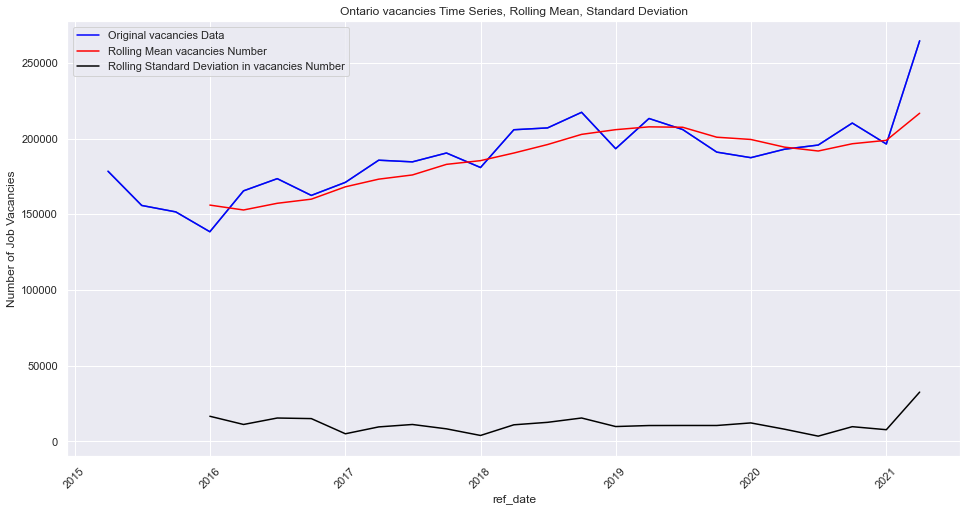

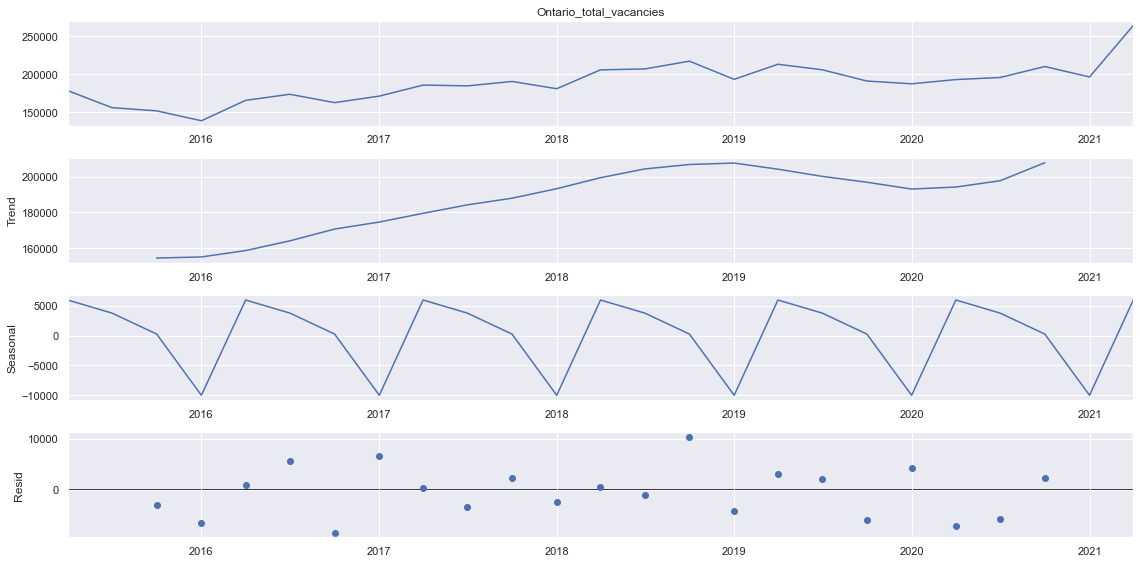

                                      SARIMAX Results                                      
Dep. Variable:                       train_Ontario   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                -121.401
Date:                             Thu, 02 Dec 2021   AIC                            250.802
Time:                                     00:41:01   BIC                            252.394
Sample:                                 04-01-2015   HQIC                           249.799
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        190.4976    984.234      0.194      0.847   -1738.566    2119.562
ar.S.L4       -0.9466      

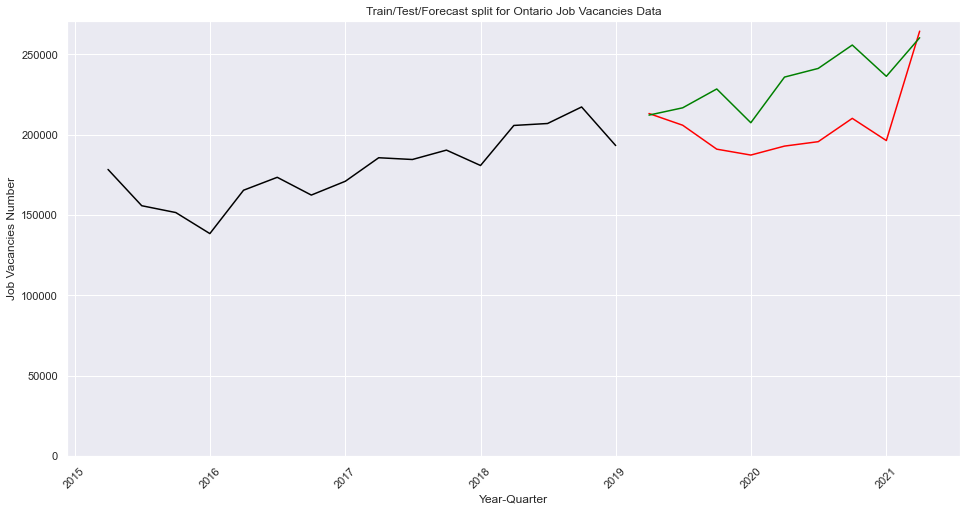

RMSE is 32594.042670331684


,test_Ontario,Prediction_Ontario
ref_date,,
2019-04-01,213225.0000,212247.738633
2019-07-01,205935.0000,216786.847081
2019-10-01,191030.0000,228520.185484
2020-01-01,187360.0000,207493.626814
2020-04-01,192941.8119,235924.036369
2020-07-01,195694.8163,241312.309931
2020-10-01,210215.0000,255879.818607
2021-01-01,196385.0000,236401.157702
2021-04-01,264530.0000,260436.820789


In [292]:
province_vac ('Ontario')

Stationary Test Results
      Values                       Metric
0  -0.076956              Test Statistics
1   0.951686                      p-value
2   7.000000             No. of lags used
3  17.000000  Number of observations used
4  -3.889266          critical value (1%)
5  -3.054358          critical value (5%)
6  -2.666984         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6697224585822976
Two Quaretrs Lag:  0.6758661167080273
Three Quaretrs Lag:  0.5121048632270006
Four Quaretrs Lag:  0.5183513350392196
Trend Decomposition Visualization


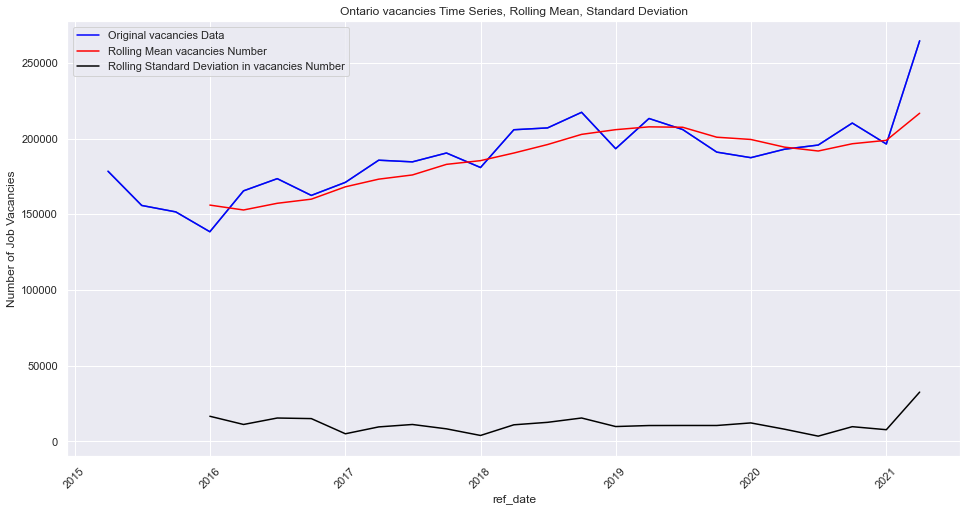

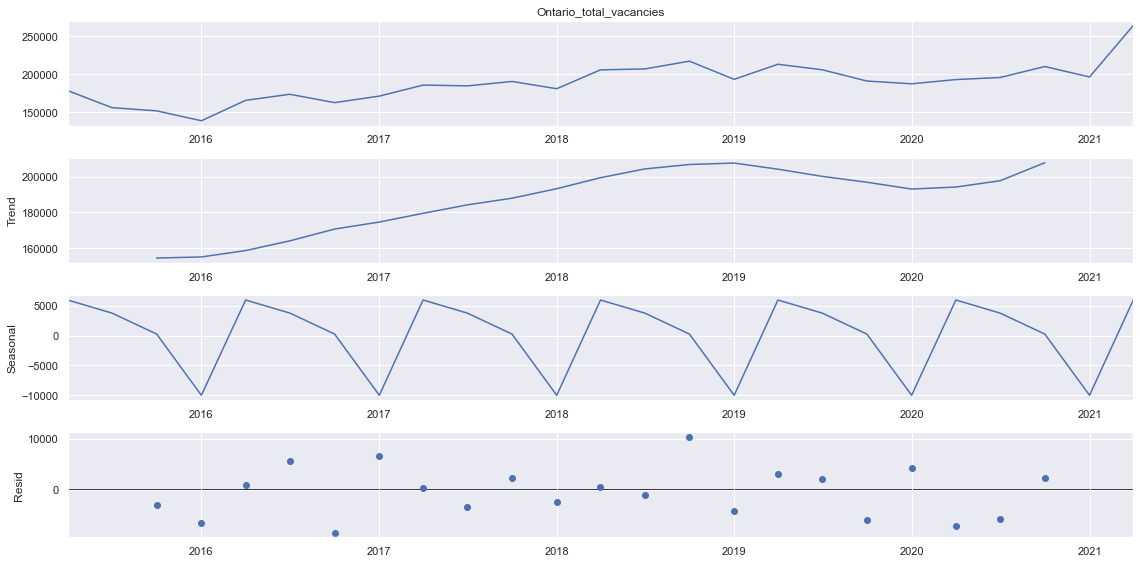

                                      SARIMAX Results                                      
Dep. Variable:                       train_Ontario   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                -121.401
Date:                             Thu, 02 Dec 2021   AIC                            250.802
Time:                                     00:41:03   BIC                            252.394
Sample:                                 04-01-2015   HQIC                           249.799
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        190.4976    984.234      0.194      0.847   -1738.566    2119.562
ar.S.L4       -0.9466      

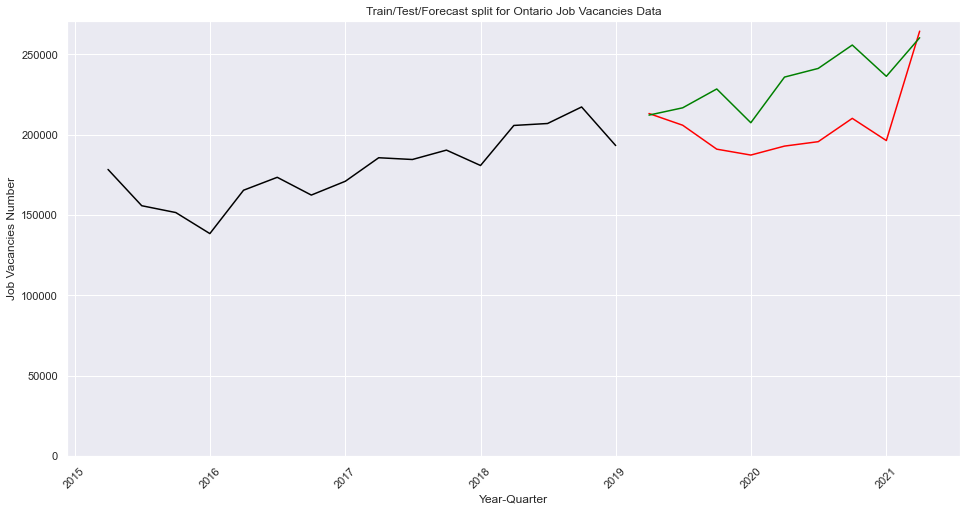

RMSE is 32594.042670331684
Stationary Test Results
      Values                       Metric
0   1.815474              Test Statistics
1   0.998379                      p-value
2   7.000000             No. of lags used
3  17.000000  Number of observations used
4  -3.889266          critical value (1%)
5  -3.054358          critical value (5%)
6  -2.666984         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.9367128653017587
Two Quaretrs Lag:  0.9120243990796175
Three Quaretrs Lag:  0.8823146625462845
Four Quaretrs Lag:  0.8936462164831976
Trend Decomposition Visualization


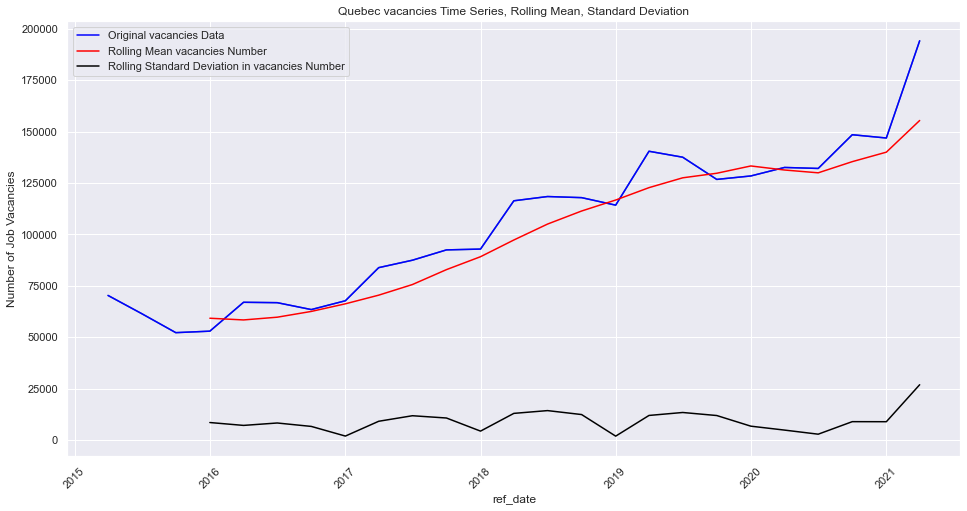

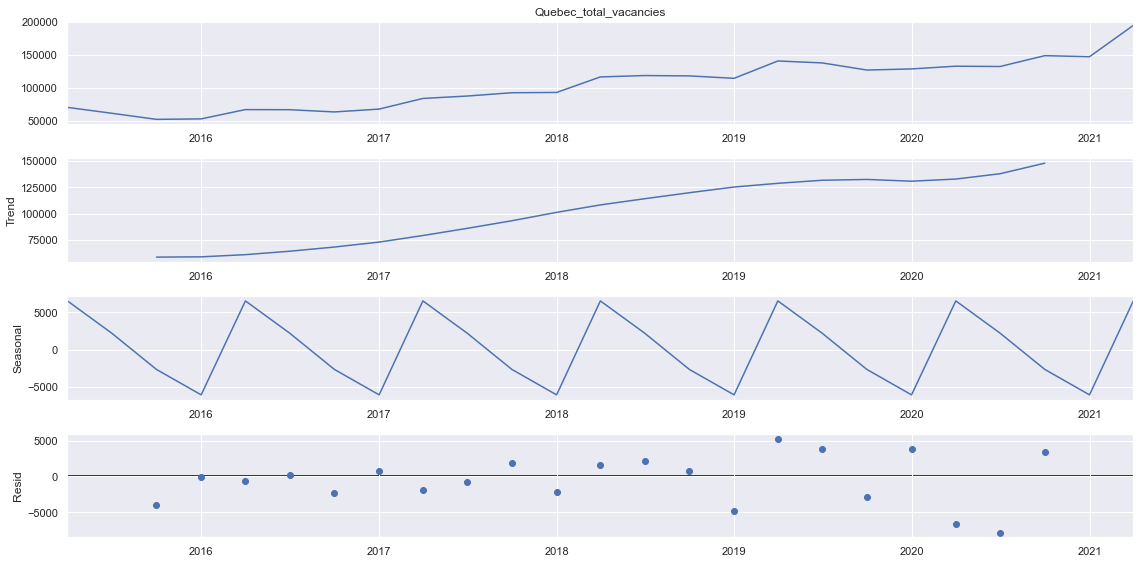

                                      SARIMAX Results                                      
Dep. Variable:                        train_Quebec   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                -107.786
Date:                             Thu, 02 Dec 2021   AIC                            223.572
Time:                                     00:41:06   BIC                            225.163
Sample:                                 04-01-2015   HQIC                           222.568
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         39.7805     77.774      0.511      0.609    -112.655     192.216
ar.S.L4        0.3635      

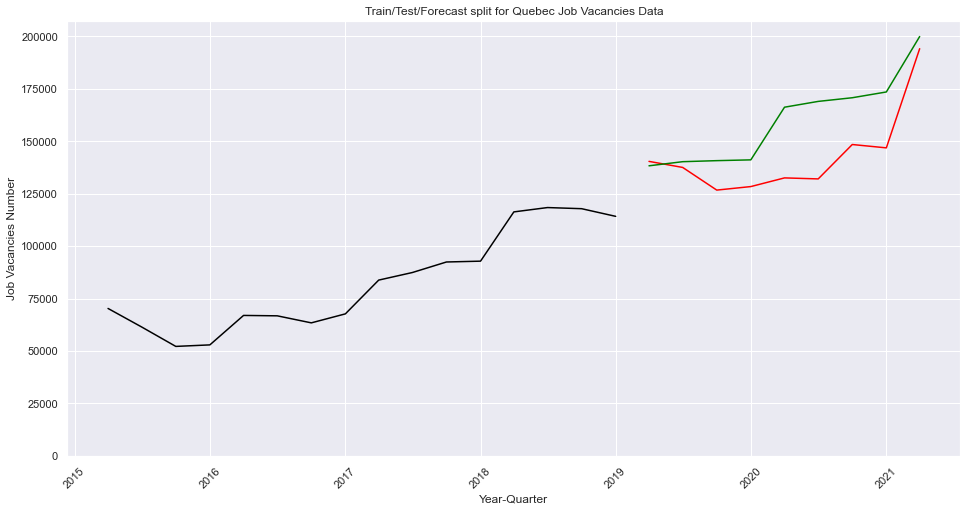

RMSE is 21381.377102911167
Stationary Test Results
      Values                       Metric
0  -1.813957              Test Statistics
1   0.373555                      p-value
2   8.000000             No. of lags used
3  16.000000  Number of observations used
4  -3.924019          critical value (1%)
5  -3.068498          critical value (5%)
6  -2.673893         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.8483707065024284
Two Quaretrs Lag:  0.7005846207322345
Three Quaretrs Lag:  0.7504770004137977
Four Quaretrs Lag:  0.7503639897053843
Trend Decomposition Visualization


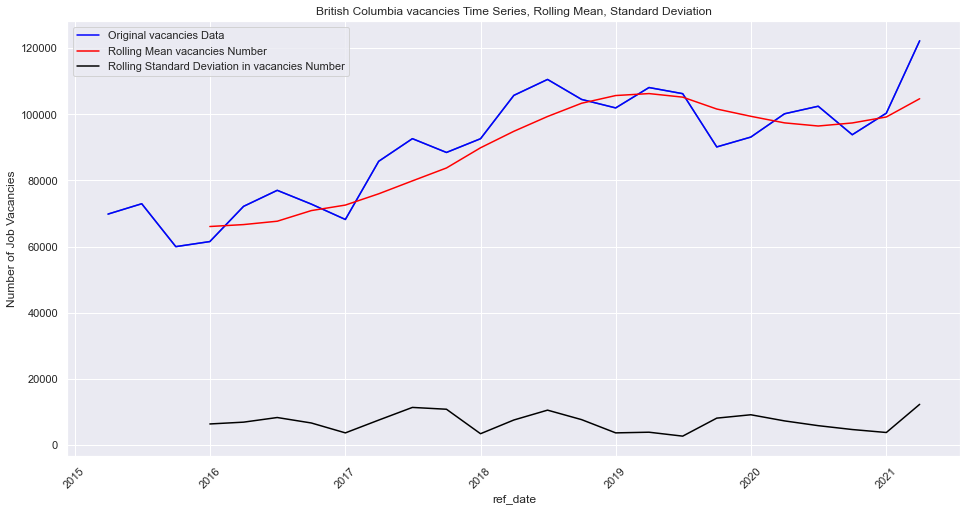

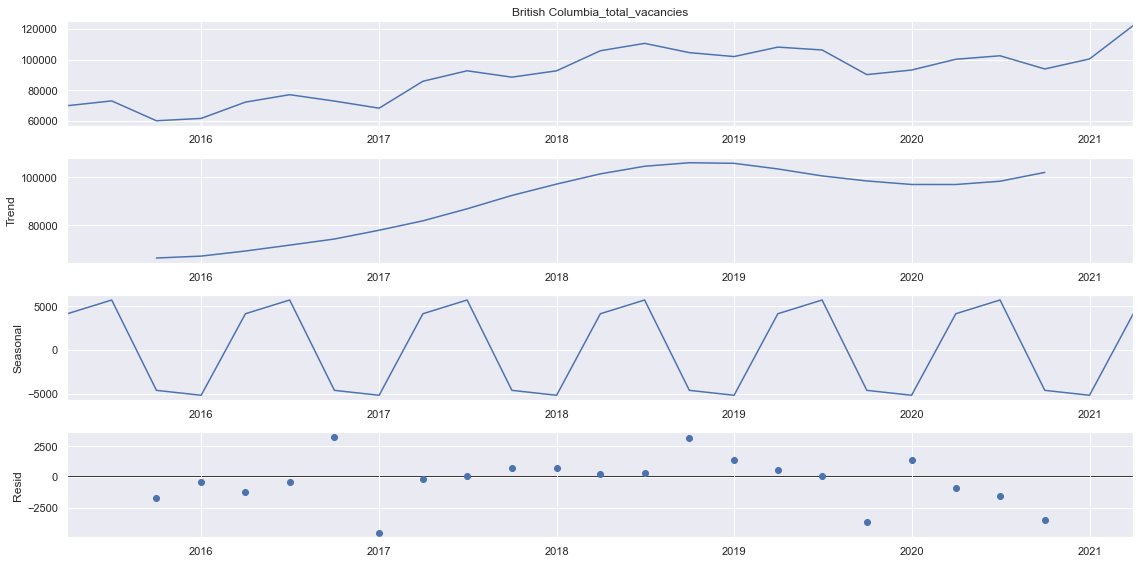

                                      SARIMAX Results                                      
Dep. Variable:              train_British Columbia   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                -106.972
Date:                             Thu, 02 Dec 2021   AIC                            221.944
Time:                                     00:41:08   BIC                            223.535
Sample:                                 04-01-2015   HQIC                           220.940
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -41.9835     94.556     -0.444      0.657    -227.310     143.343
ar.S.L4        0.3294      

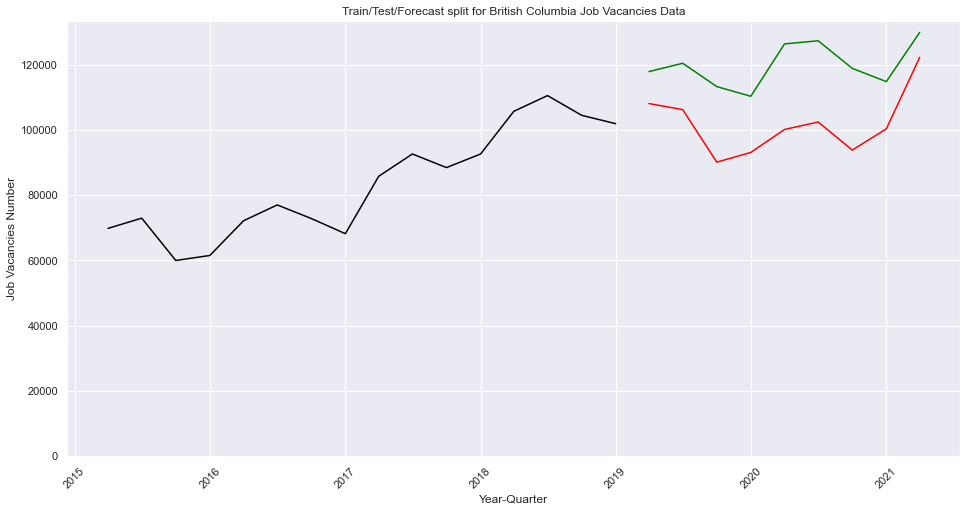

RMSE is 19267.848179428278
Stationary Test Results
      Values                       Metric
0  -2.826318              Test Statistics
1   0.054612                      p-value
2   8.000000             No. of lags used
3  16.000000  Number of observations used
4  -3.924019          critical value (1%)
5  -3.068498          critical value (5%)
6  -2.673893         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.538104401345235
Two Quaretrs Lag:  -0.03025311918816651
Three Quaretrs Lag:  -0.13542321037588334
Four Quaretrs Lag:  -0.12476405523916803
Trend Decomposition Visualization


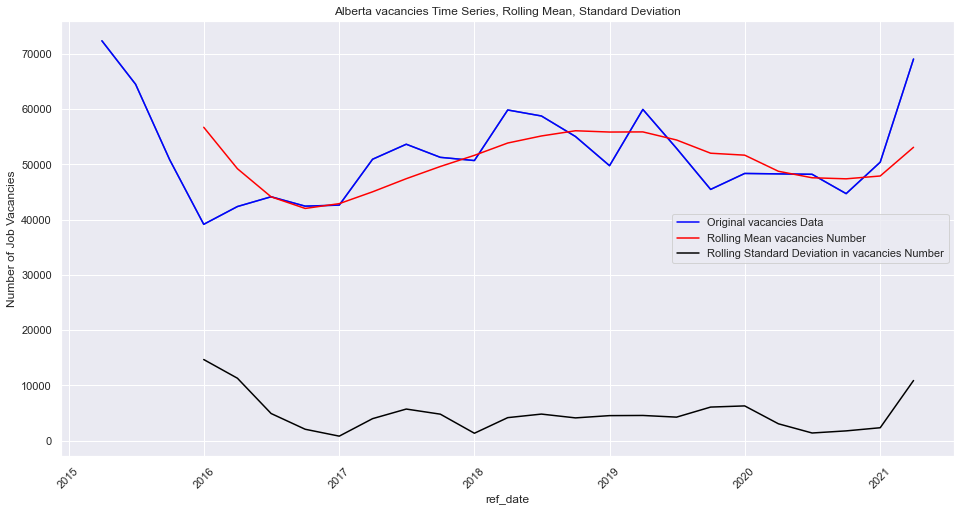

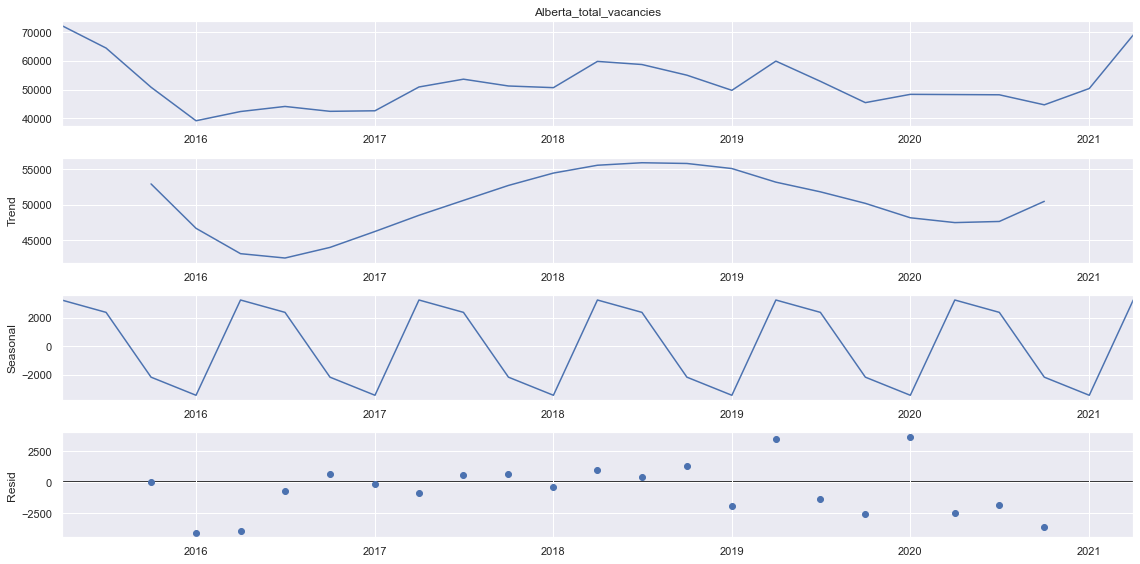

                                      SARIMAX Results                                      
Dep. Variable:                       train_Alberta   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                -108.485
Date:                             Thu, 02 Dec 2021   AIC                            224.971
Time:                                     00:41:10   BIC                            226.562
Sample:                                 04-01-2015   HQIC                           223.967
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -15.2417    162.690     -0.094      0.925    -334.109     303.626
ar.S.L4        0.4177      

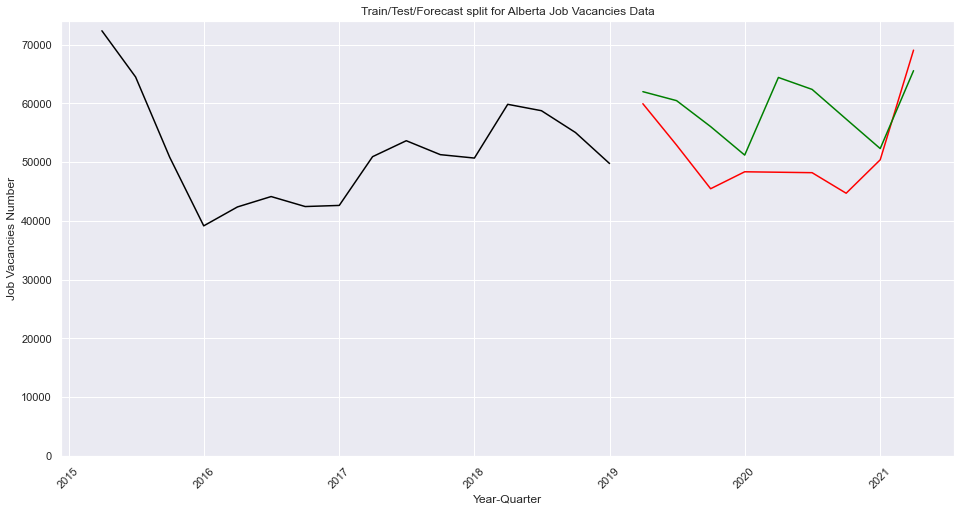

RMSE is 9530.314230358477
Stationary Test Results
      Values                       Metric
0  -0.391978              Test Statistics
1   0.911430                      p-value
2   5.000000             No. of lags used
3  19.000000  Number of observations used
4  -3.832603          critical value (1%)
5  -3.031227          critical value (5%)
6  -2.655520         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.8142787295268843
Two Quaretrs Lag:  0.773907407392514
Three Quaretrs Lag:  0.7051690123536882
Four Quaretrs Lag:  0.7443969090795263
Trend Decomposition Visualization


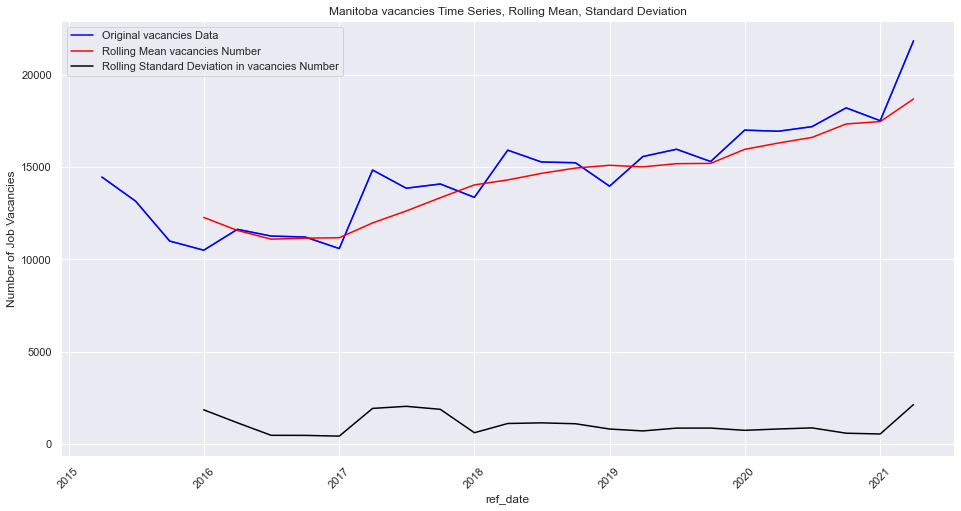

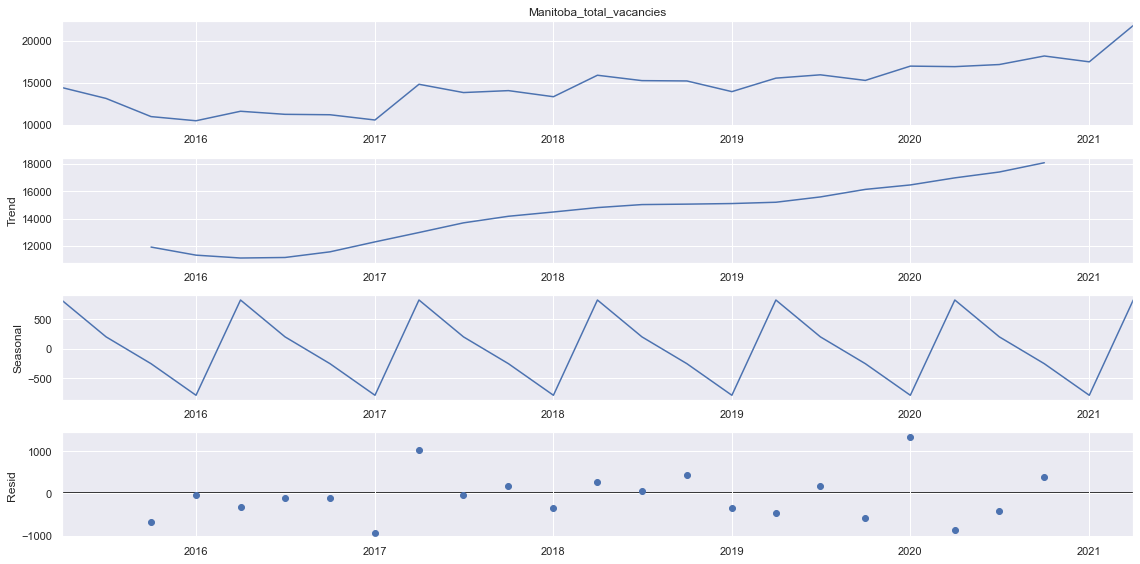

                                      SARIMAX Results                                      
Dep. Variable:                      train_Manitoba   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -87.582
Date:                             Thu, 02 Dec 2021   AIC                            183.165
Time:                                     00:41:12   BIC                            184.757
Sample:                                 04-01-2015   HQIC                           182.162
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          8.3419     44.535      0.187      0.851     -78.945      95.629
ar.S.L4       -0.5264      

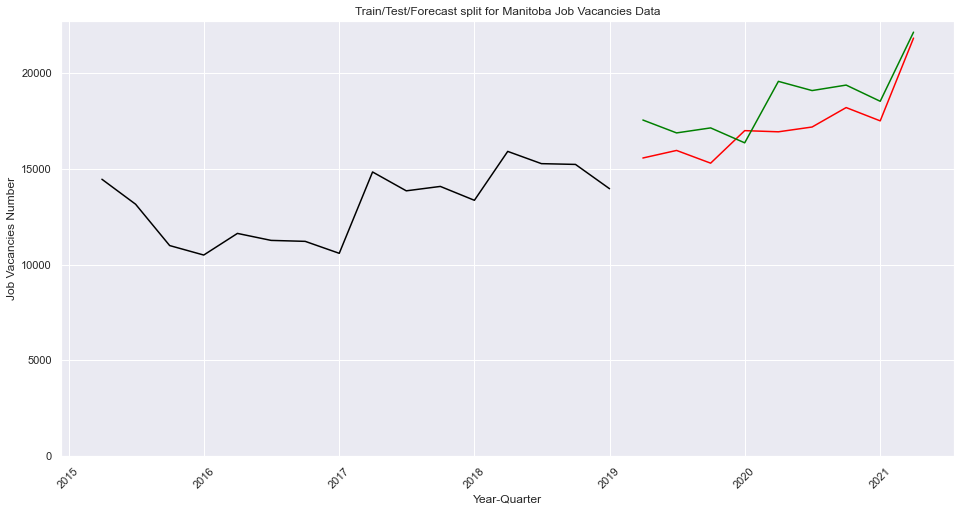

RMSE is 1551.928617036526
Stationary Test Results
      Values                       Metric
0   2.074890              Test Statistics
1   0.998763                      p-value
2   7.000000             No. of lags used
3  17.000000  Number of observations used
4  -3.889266          critical value (1%)
5  -3.054358          critical value (5%)
6  -2.666984         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.4429502047632673
Two Quaretrs Lag:  0.027564968362396556
Three Quaretrs Lag:  0.1260514323017731
Four Quaretrs Lag:  0.26317854175517696
Trend Decomposition Visualization


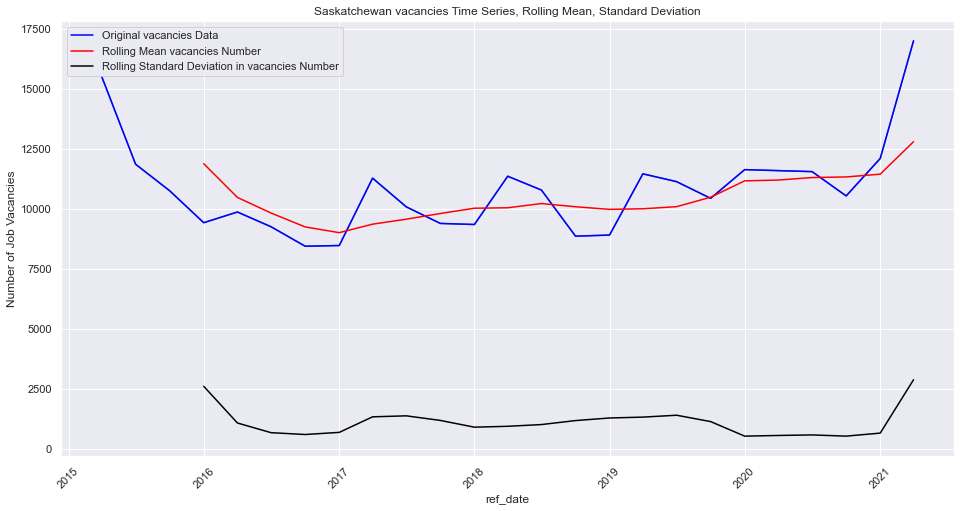

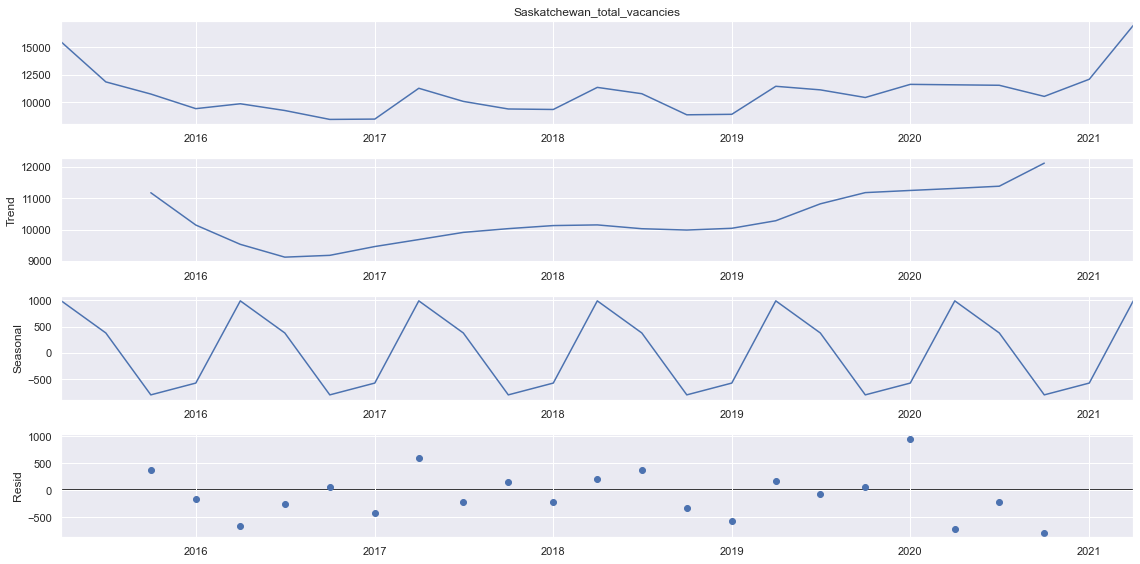

                                      SARIMAX Results                                      
Dep. Variable:                  train_Saskatchewan   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -89.963
Date:                             Thu, 02 Dec 2021   AIC                            187.926
Time:                                     00:41:15   BIC                            189.517
Sample:                                 04-01-2015   HQIC                           186.922
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         14.4932     37.735      0.384      0.701     -59.466      88.453
ar.S.L4       -0.3449      

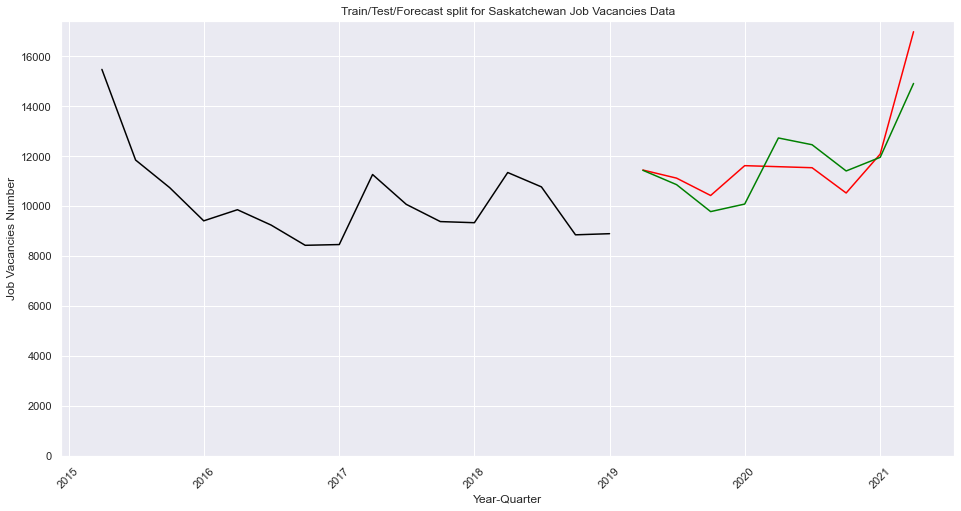

RMSE is 1060.0594873191196
Stationary Test Results
      Values                       Metric
0  -3.523826              Test Statistics
1   0.007396                      p-value
2   9.000000             No. of lags used
3  15.000000  Number of observations used
4  -3.964443          critical value (1%)
5  -3.084908          critical value (5%)
6  -2.681814         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6282796536620598
Two Quaretrs Lag:  0.40582105203812147
Three Quaretrs Lag:  0.4670556033892479
Four Quaretrs Lag:  0.746644109684907
Trend Decomposition Visualization


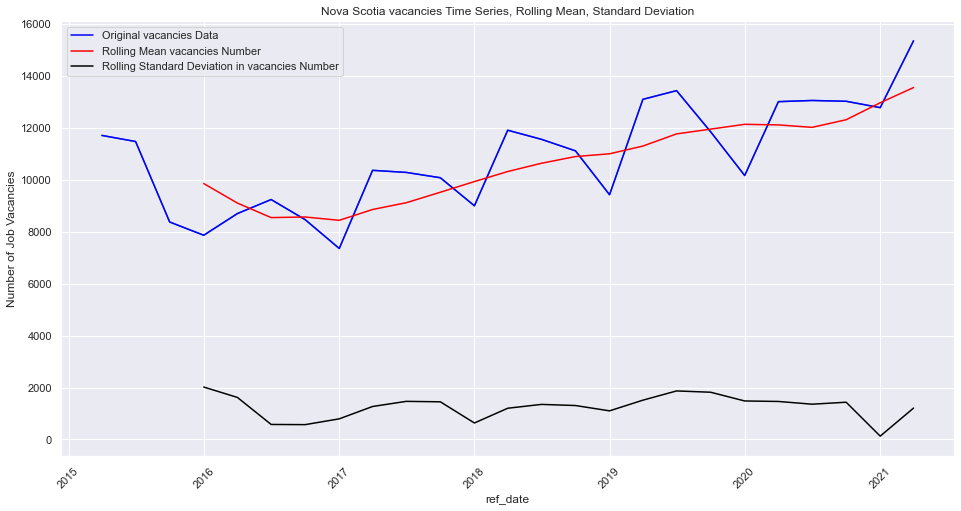

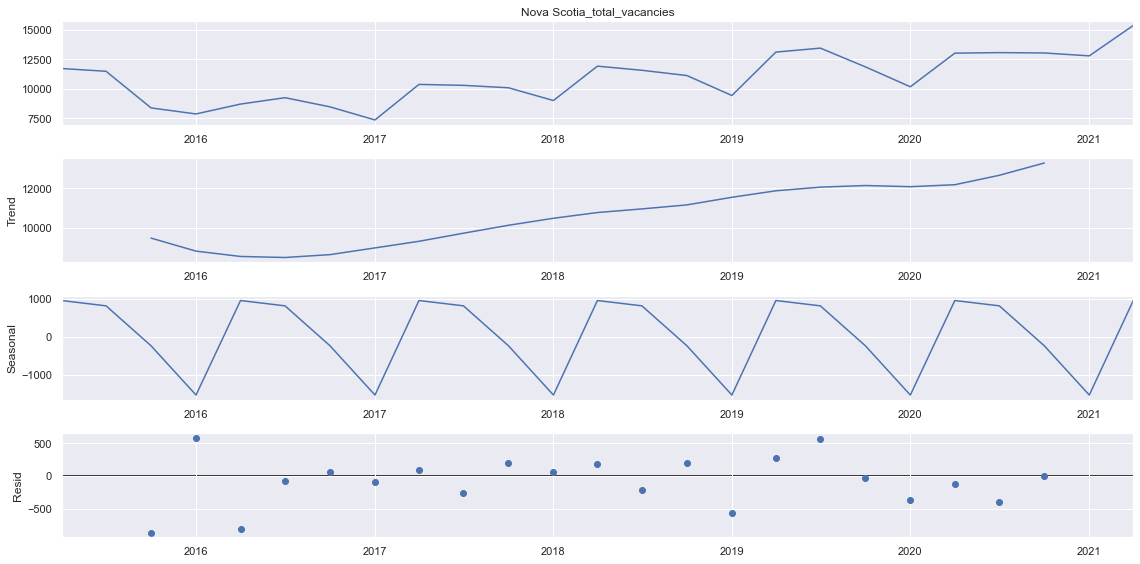

                                      SARIMAX Results                                      
Dep. Variable:                   train_Nova Scotia   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -89.106
Date:                             Thu, 02 Dec 2021   AIC                            186.212
Time:                                     00:41:16   BIC                            187.804
Sample:                                 04-01-2015   HQIC                           185.209
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          3.7801     31.025      0.122      0.903     -57.028      64.588
ar.S.L4       -0.0576      

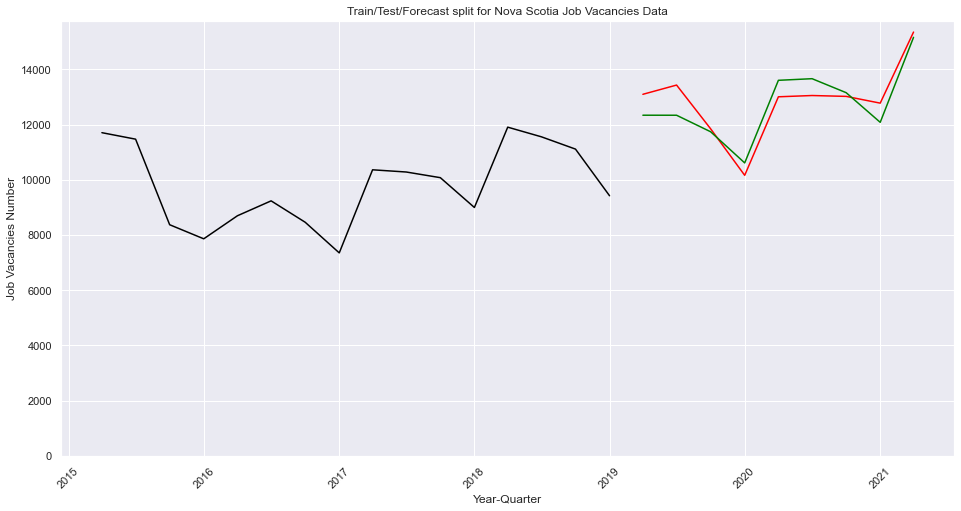

RMSE is 600.7301880128805
Stationary Test Results
      Values                       Metric
0   1.106262              Test Statistics
1   0.995270                      p-value
2   3.000000             No. of lags used
3  21.000000  Number of observations used
4  -3.788386          critical value (1%)
5  -3.013098          critical value (5%)
6  -2.646397         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6053190502244364
Two Quaretrs Lag:  0.565945457580359
Three Quaretrs Lag:  0.48419168363882
Four Quaretrs Lag:  0.7791124226199604
Trend Decomposition Visualization


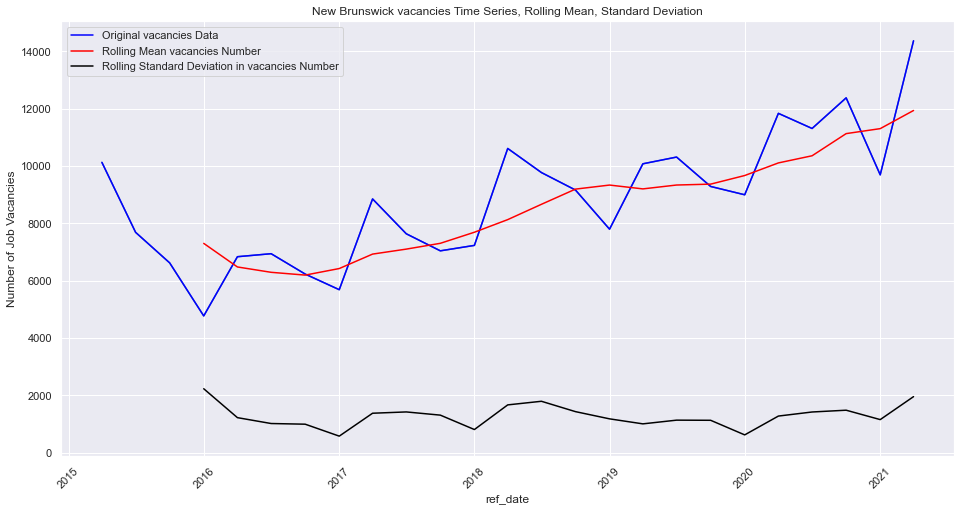

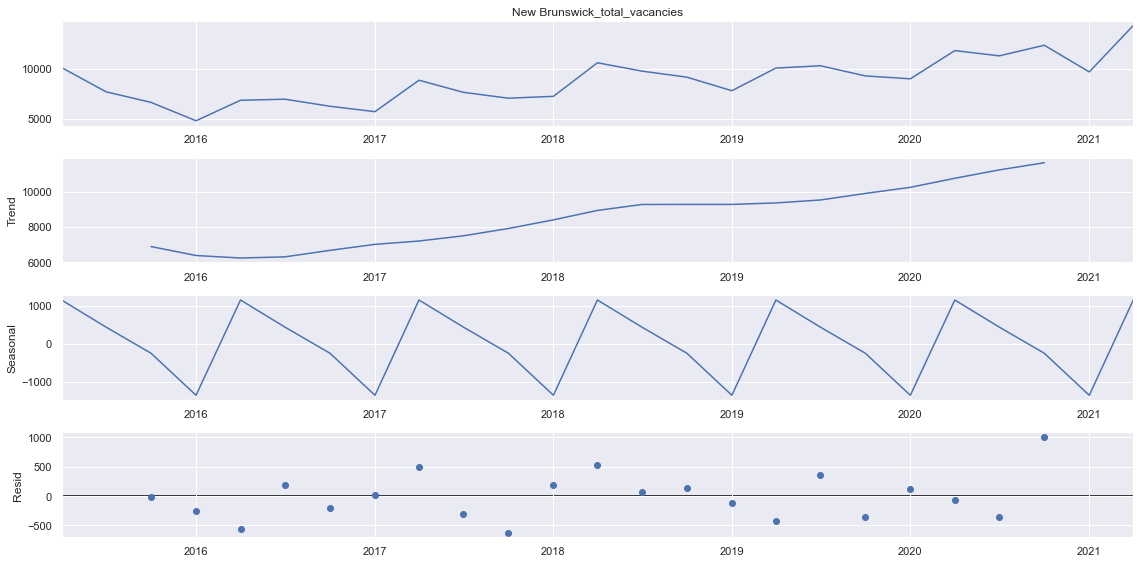

                                      SARIMAX Results                                      
Dep. Variable:                 train_New Brunswick   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -87.828
Date:                             Thu, 02 Dec 2021   AIC                            183.657
Time:                                     00:41:19   BIC                            185.248
Sample:                                 04-01-2015   HQIC                           182.654
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         11.3116     25.664      0.441      0.659     -38.989      61.612
ar.S.L4       -0.2586      

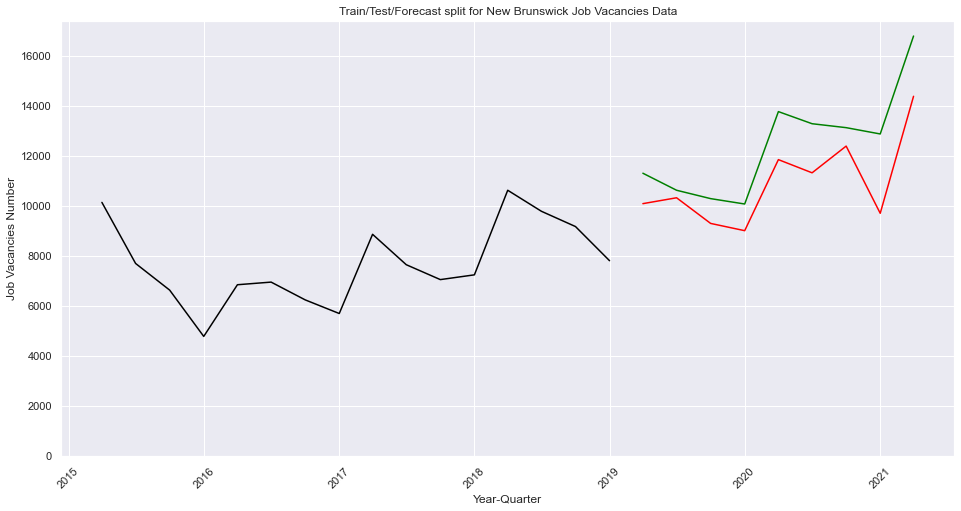

RMSE is 1751.2324355215314
Stationary Test Results
      Values                       Metric
0  -2.318937              Test Statistics
1   0.165933                      p-value
2   8.000000             No. of lags used
3  16.000000  Number of observations used
4  -3.924019          critical value (1%)
5  -3.068498          critical value (5%)
6  -2.673893         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.2500486964494063
Two Quaretrs Lag:  0.3473253972156805
Three Quaretrs Lag:  0.23150820740729242
Four Quaretrs Lag:  0.5089098151745148
Trend Decomposition Visualization


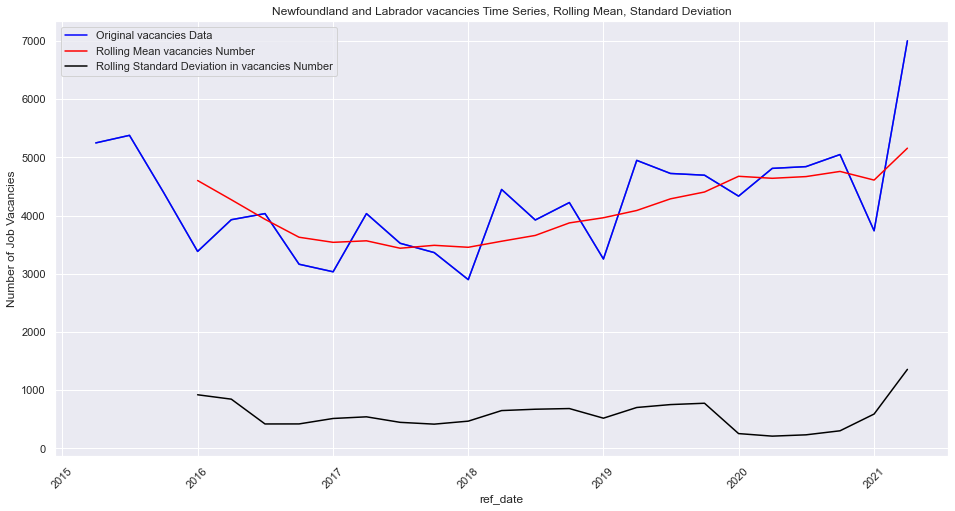

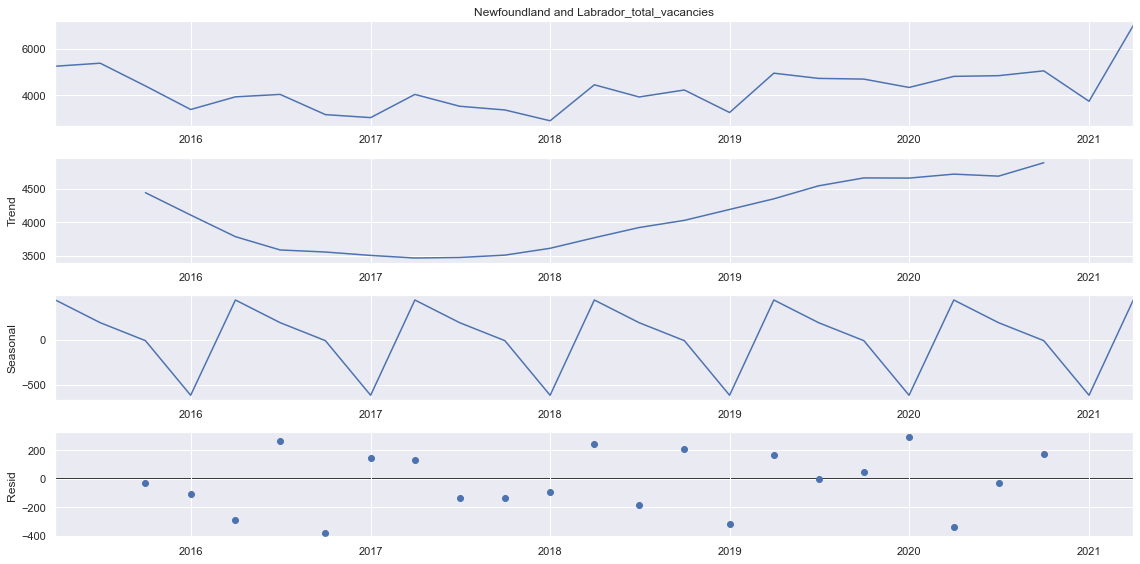

                                      SARIMAX Results                                      
Dep. Variable:     train_Newfoundland and Labrador   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -83.284
Date:                             Thu, 02 Dec 2021   AIC                            174.568
Time:                                     00:41:20   BIC                            176.160
Sample:                                 04-01-2015   HQIC                           173.565
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         19.3580     22.061      0.877      0.380     -23.880      62.596
ar.S.L4       -0.6475      

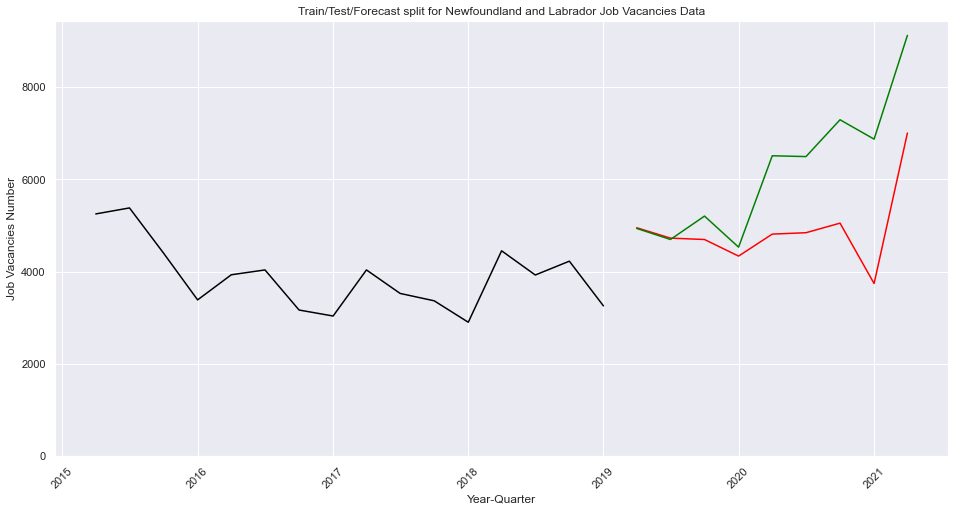

RMSE is 1674.9615459125855
Stationary Test Results
      Values                       Metric
0  -0.735839              Test Statistics
1   0.837247                      p-value
2   9.000000             No. of lags used
3  15.000000  Number of observations used
4  -3.964443          critical value (1%)
5  -3.084908          critical value (5%)
6  -2.681814         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.25360963296194
Two Quaretrs Lag:  -0.022515895912721944
Three Quaretrs Lag:  0.22636175318709068
Four Quaretrs Lag:  0.7714831807843054
Trend Decomposition Visualization


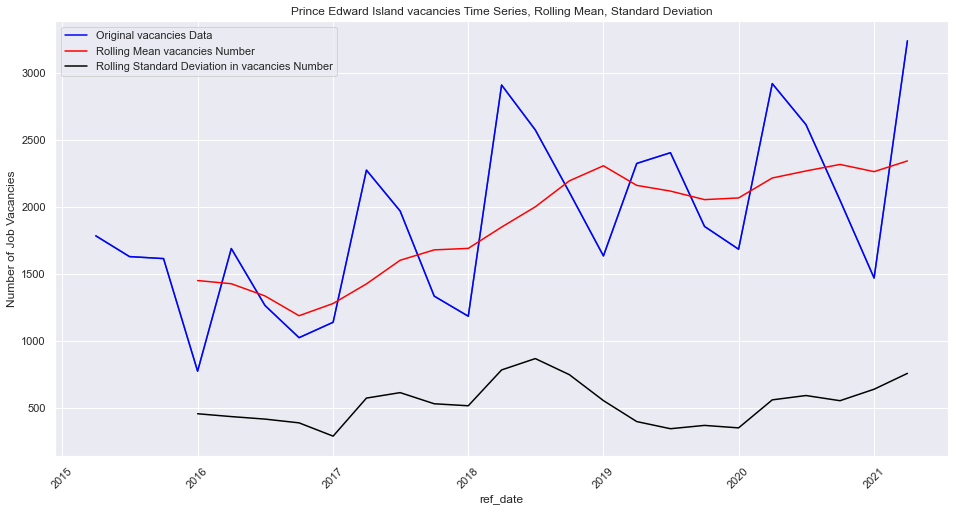

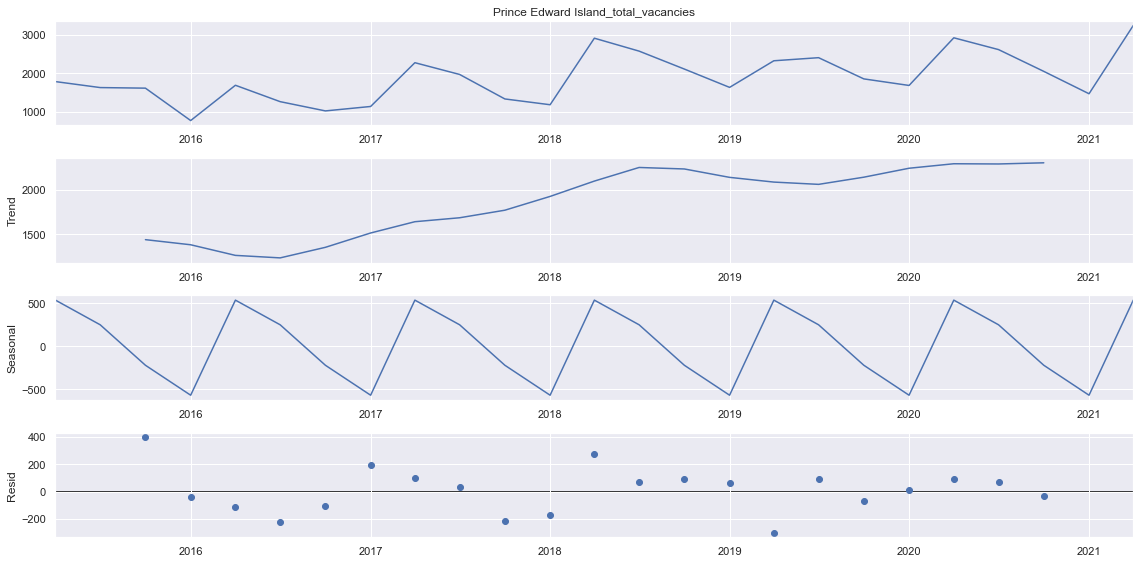

                                      SARIMAX Results                                      
Dep. Variable:          train_Prince Edward Island   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -81.286
Date:                             Thu, 02 Dec 2021   AIC                            170.572
Time:                                     00:41:22   BIC                            172.164
Sample:                                 04-01-2015   HQIC                           169.569
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          1.3715     10.898      0.126      0.900     -19.988      22.731
ar.S.L4        0.3765      

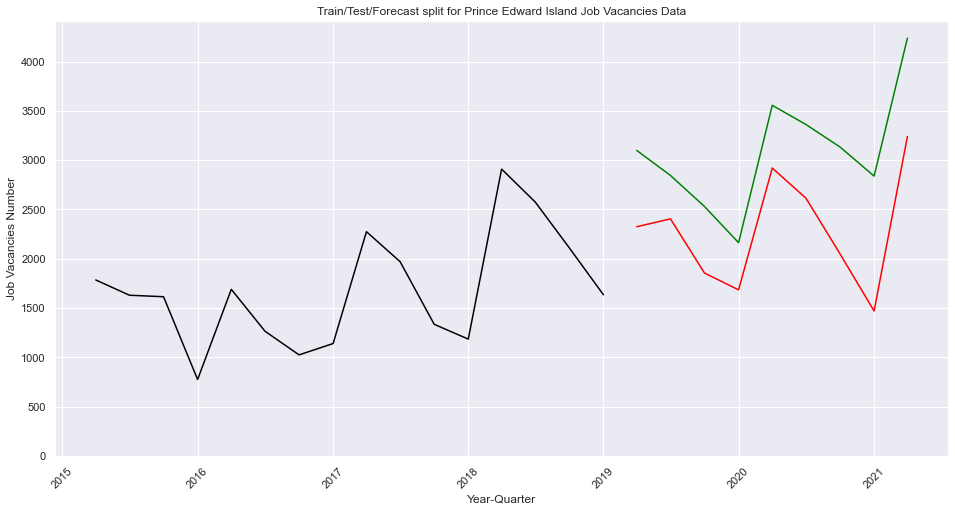

RMSE is 849.0855938614172
Stationary Test Results
      Values                       Metric
0  -1.154288              Test Statistics
1   0.692945                      p-value
2   9.000000             No. of lags used
3  15.000000  Number of observations used
4  -3.964443          critical value (1%)
5  -3.084908          critical value (5%)
6  -2.681814         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.5088271248293982
Two Quaretrs Lag:  0.26435117045627493
Three Quaretrs Lag:  0.5526379603931018
Four Quaretrs Lag:  0.7782743437690691
Trend Decomposition Visualization


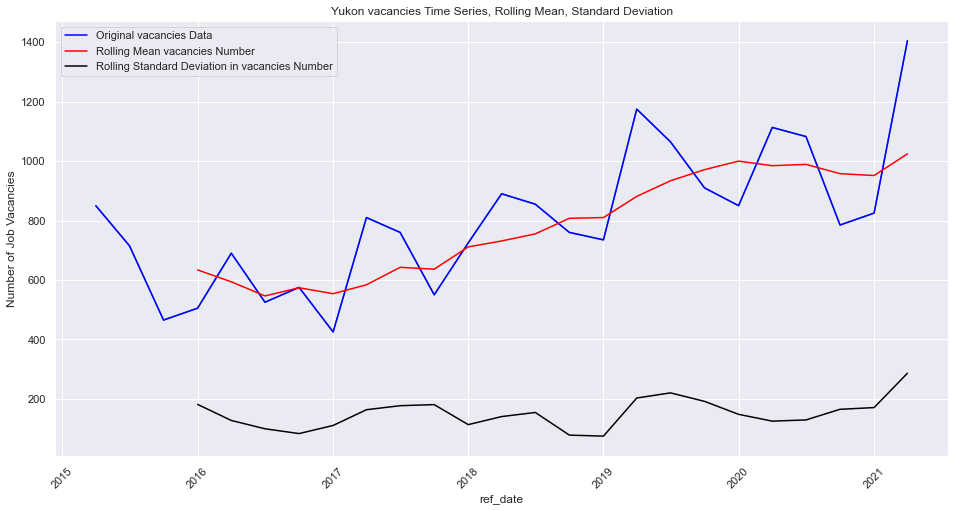

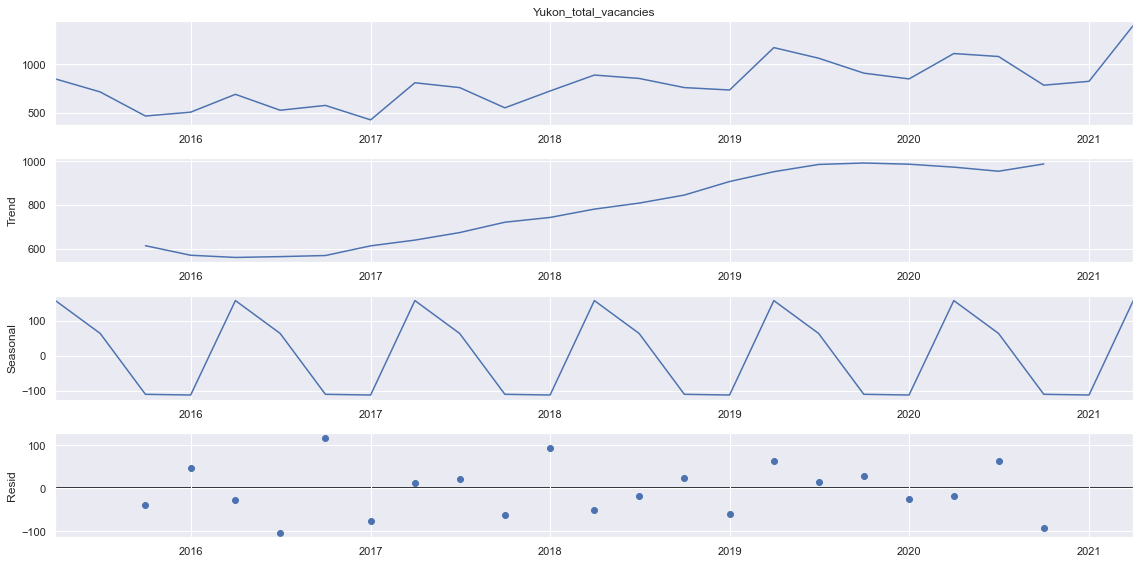

                                      SARIMAX Results                                      
Dep. Variable:                         train_Yukon   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -68.159
Date:                             Thu, 02 Dec 2021   AIC                            144.318
Time:                                     00:41:25   BIC                            145.910
Sample:                                 04-01-2015   HQIC                           143.315
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          3.3174      2.911      1.139      0.255      -2.389       9.024
ar.S.L4       -0.6415      

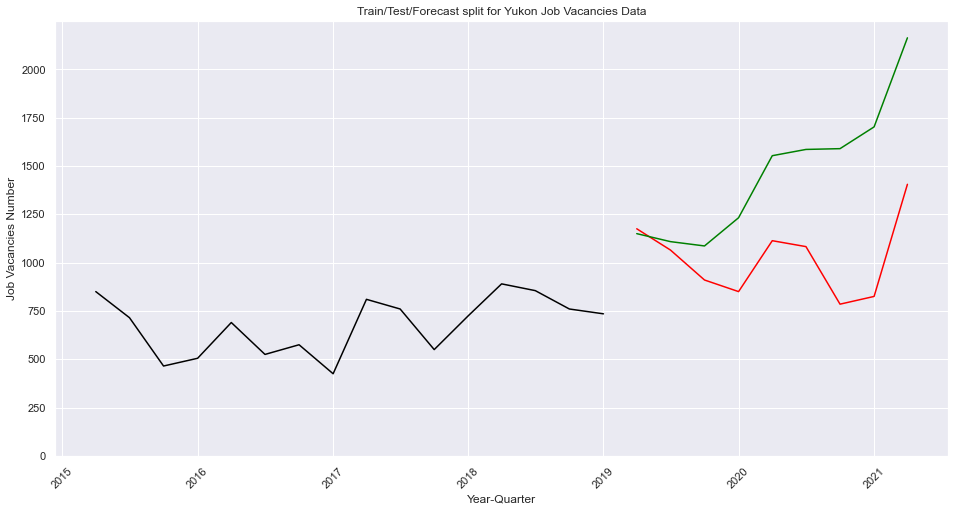

RMSE is 539.1825352796135
Stationary Test Results
      Values                       Metric
0  -0.538492              Test Statistics
1   0.884284                      p-value
2   2.000000             No. of lags used
3  22.000000  Number of observations used
4  -3.769733          critical value (1%)
5  -3.005426          critical value (5%)
6  -2.642501         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.602446854043515
Two Quaretrs Lag:  0.21131682008872446
Three Quaretrs Lag:  0.3607903139276032
Four Quaretrs Lag:  0.47877253786135177
Trend Decomposition Visualization


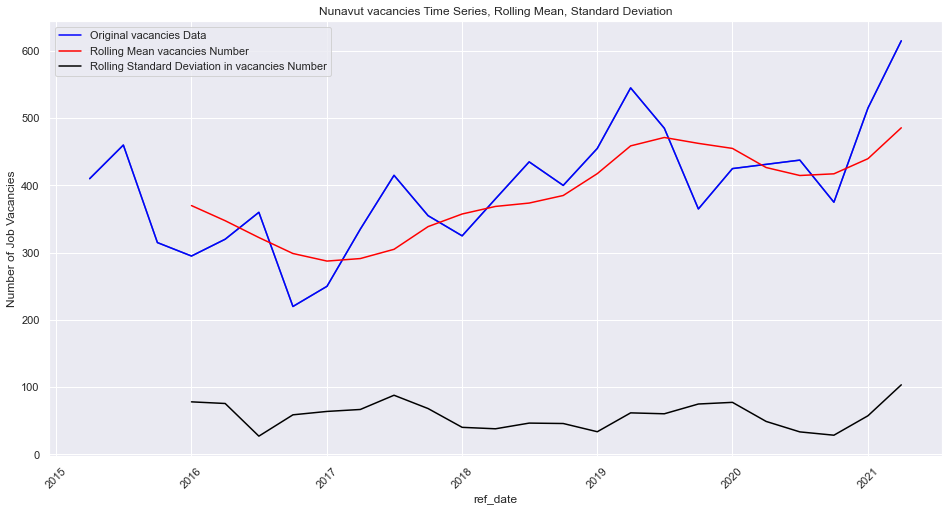

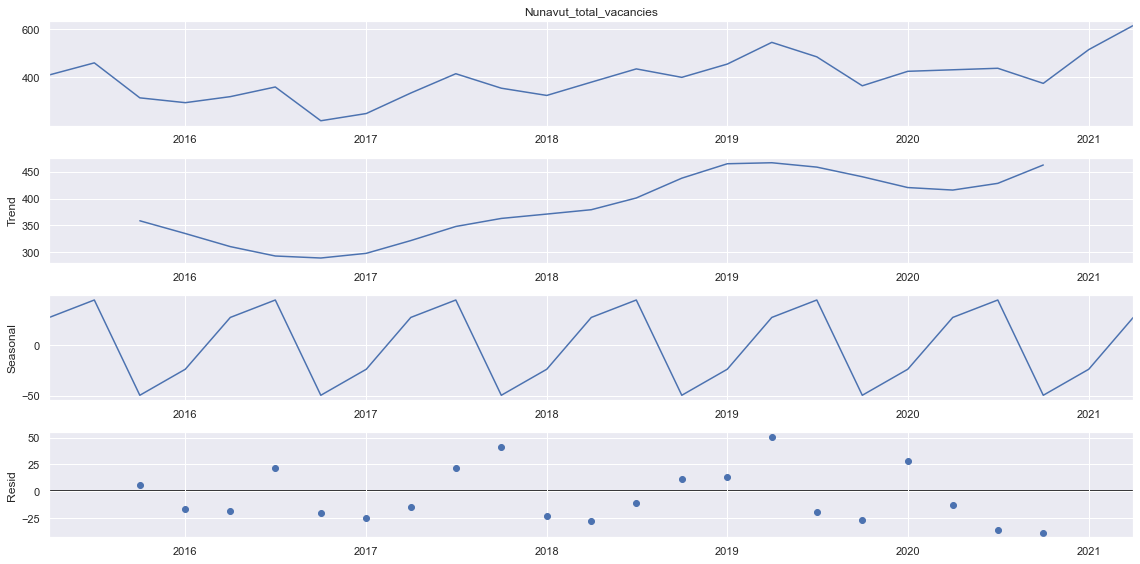

                                      SARIMAX Results                                      
Dep. Variable:                       train_Nunavut   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -54.642
Date:                             Thu, 02 Dec 2021   AIC                            117.284
Time:                                     00:41:27   BIC                            118.875
Sample:                                 04-01-2015   HQIC                           116.281
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          3.1693      1.247      2.541      0.011       0.724       5.614
ar.S.L4       -0.9999      

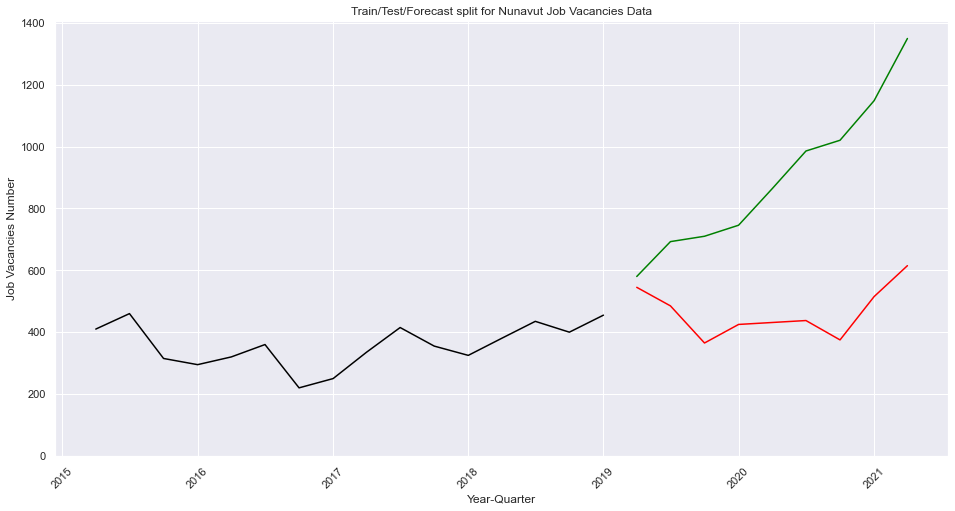

RMSE is 484.3185127523854
Stationary Test Results
      Values                       Metric
0  -2.855894              Test Statistics
1   0.050723                      p-value
2   3.000000             No. of lags used
3  21.000000  Number of observations used
4  -3.788386          critical value (1%)
5  -3.013098          critical value (5%)
6  -2.646397         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6220667508836611
Two Quaretrs Lag:  0.09221660903272232
Three Quaretrs Lag:  -0.23320948715617024
Four Quaretrs Lag:  -0.5026472260459147
Trend Decomposition Visualization


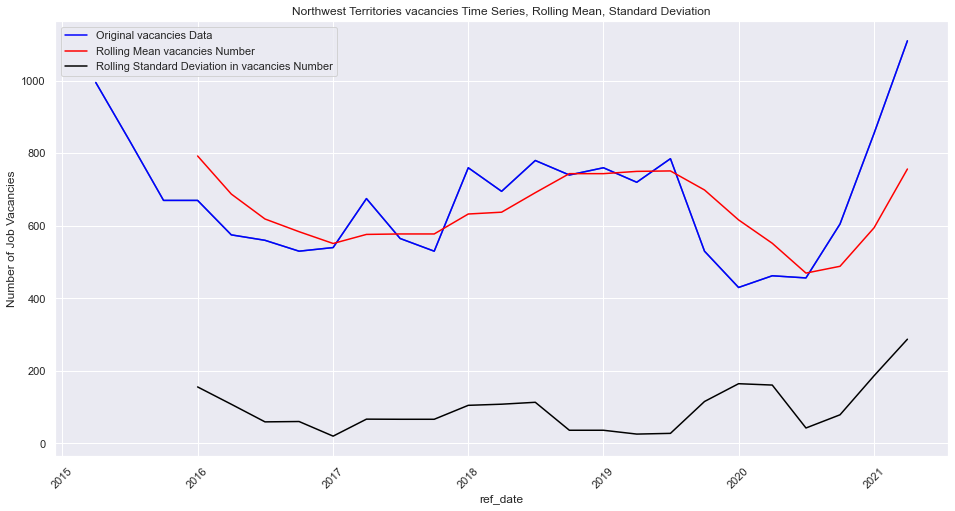

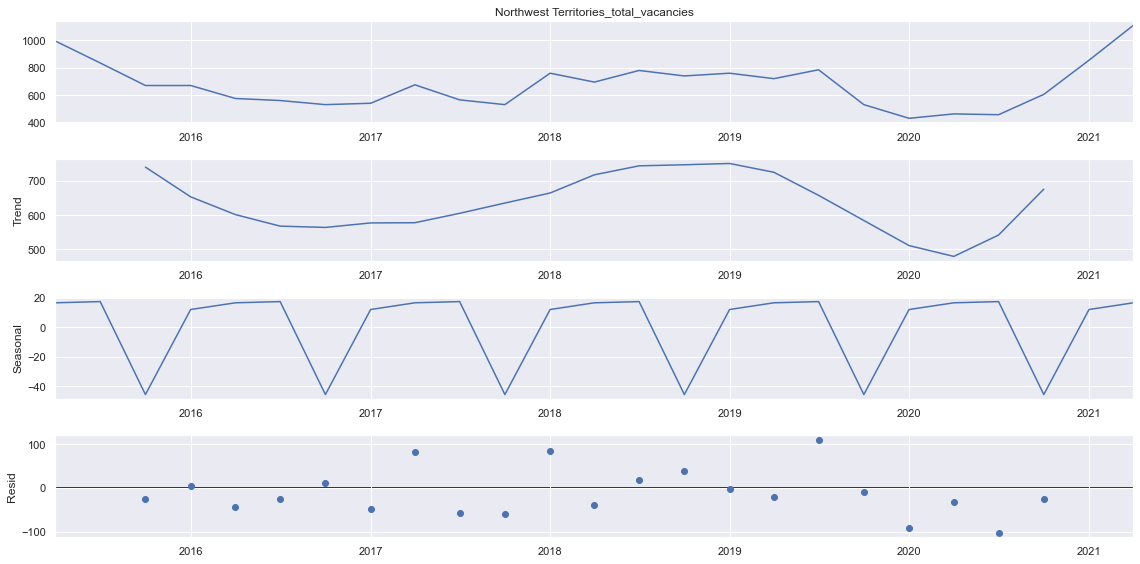

                                      SARIMAX Results                                      
Dep. Variable:         train_Northwest Territories   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -65.133
Date:                             Thu, 02 Dec 2021   AIC                            138.267
Time:                                     00:41:29   BIC                            139.858
Sample:                                 04-01-2015   HQIC                           137.263
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          5.8267      2.606      2.236      0.025       0.719      10.934
ar.S.L4       -0.8017      

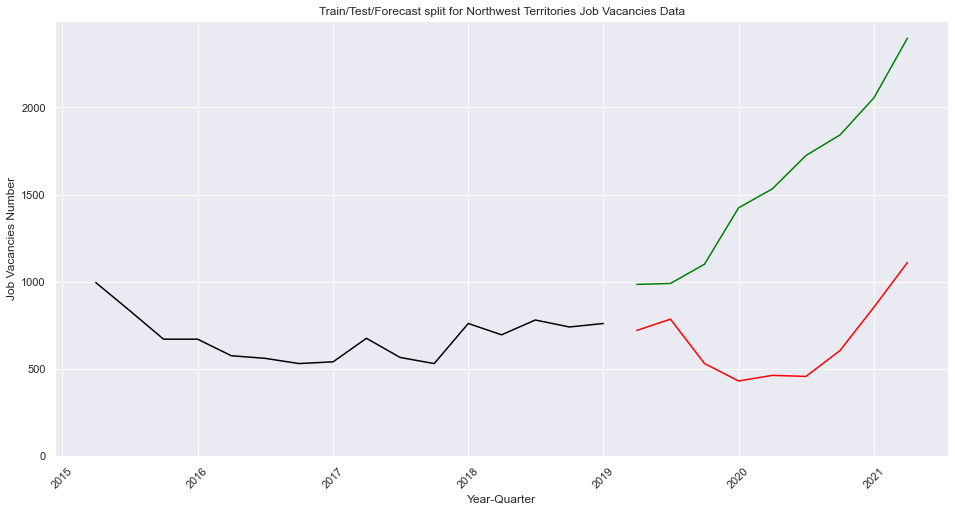

RMSE is 989.3950924732669
            test_Ontario  Prediction_Ontario  test_Quebec  Prediction_Quebec  \
ref_date                                                                       
2019-04-01   213225.0000       212247.738633  140420.0000      138309.084788   
2019-07-01   205935.0000       216786.847081  137530.0000      140275.311525   
2019-10-01   191030.0000       228520.185484  126730.0000      140769.287911   
2020-01-01   187360.0000       207493.626814  128410.0000      141143.186245   
2020-04-01   192941.8119       235924.036369  132545.1835      166254.297965   
2020-07-01   195694.8163       241312.309931  132064.3476      169018.191871   
2020-10-01   210215.0000       255879.818607  148460.0000      170763.214116   
2021-01-01   196385.0000       236401.157702  146865.0000      173514.844218   
2021-04-01   264530.0000       260436.820789  194145.0000      199950.401341   

            test_British Columbia  Prediction_British Columbia  test_Alberta  \
ref_date     

In [293]:
# produce all provinces prediction test results
provinces = ['Ontario', 'Quebec', 'British Columbia','Alberta',\
             'Manitoba', 'Saskatchewan','Nova Scotia', 'New Brunswick','Newfoundland and Labrador',\
             'Prince Edward Island', 'Yukon', 'Nunavut' ,'Northwest Territories']

output_provencies= province_vac("Ontario")

for prov in provinces[1:13]:
    output_provencies = pd.merge(output_provencies , province_vac(prov), left_index=True, right_index=True)
          
    
#output_provencies
print(output_provencies)

In [294]:
output_provencies

,test_Ontario,Prediction_Ontario,test_Quebec,Prediction_Quebec,test_British Columbia,Prediction_British Columbia,test_Alberta,Prediction_Alberta,test_Manitoba,Prediction_Manitoba,...,test_Newfoundland and Labrador,Prediction_Newfoundland and Labrador,test_Prince Edward Island,Prediction_Prince Edward Island,test_Yukon,Prediction_Yukon,test_Nunavut,Prediction_Nunavut,test_Northwest Territories,Prediction_Northwest Territories
ref_date,,,,,,,,,,,,,,,,,,,,,
2019-04-01,213225.0000,212247.738633,140420.0000,138309.084788,108115.0000,117918.687834,59930.00000,61983.658626,15565.00000,17549.790862,...,4950.000000,4934.927267,2325.000000,3099.342312,1175.000000,1149.838091,545.000000,580.027971,720.000000,984.337447
2019-07-01,205935.0000,216786.847081,137530.0000,140275.311525,106260.0000,120492.062567,52890.00000,60457.014969,15960.00000,16875.990683,...,4725.000000,4695.675470,2405.000000,2845.295451,1065.000000,1108.538272,485.000000,692.745599,785.000000,989.816693
2019-10-01,191030.0000,228520.185484,126730.0000,140769.287911,90140.0000,113326.123192,45465.00000,56038.204940,15295.00000,17137.680343,...,4695.000000,5202.849581,1855.000000,2530.272821,910.000000,1086.168418,365.000000,710.079425,530.000000,1100.377430
2020-01-01,187360.0000,207493.626814,128410.0000,141143.186245,93125.0000,110350.620158,48350.00000,51189.068887,16995.00000,16357.413667,...,4335.000000,4528.950866,1685.000000,2163.270240,850.000000,1232.117483,425.000000,745.732937,430.000000,1423.683814
2020-04-01,192941.8119,235924.036369,132545.1835,166254.297965,100171.1173,126424.710896,48273.51128,64400.846583,16933.82862,19569.289674,...,4812.289578,6511.914814,2920.423190,3556.903262,1113.305809,1553.042275,431.300752,864.128410,462.226052,1532.601069
2020-07-01,195694.8163,241312.309931,132064.3476,169018.191871,102454.3798,127376.339226,48197.02256,62369.666782,17184.18819,19088.462825,...,4842.348548,6494.169138,2614.571134,3362.137629,1082.704106,1585.449604,437.601504,985.691357,456.296235,1724.191501
2020-10-01,210215.0000,255879.818607,148460.0000,170763.214116,93835.0000,118919.145045,44700.00000,57321.579884,18200.00000,19374.853301,...,5050.000000,7293.081324,2050.000000,3133.755875,785.000000,1589.473670,375.000000,1020.422786,605.000000,1842.239419
2021-01-01,196385.0000,236401.157702,146865.0000,173514.844218,100365.0000,114844.438496,50390.00000,52299.756413,17505.00000,18528.636111,...,3740.000000,6872.701475,1470.000000,2838.959919,825.000000,1702.066127,515.000000,1148.313058,855.000000,2056.407244
2021-04-01,264530.0000,260436.820789,194145.0000,199950.401341,122260.0000,129943.999775,69050.00000,65556.353870,21830.00000,22139.665949,...,7005.000000,9124.051865,3240.000000,4238.886682,1405.000000,2162.851173,615.000000,1349.402414,1110.000000,2397.695582


In [295]:
#make future predictions for all provinces

future_predictions= ['2021-07-01','2021-10-01',\
                     '2022-01-01','2022-04-01','2022-07-01','2022-10-01',\
                     '2023-01-01','2023-04-01','2023-07-01','2023-10-01',\
                    '2024-01-01','2024-04-01','2024-07-01','2024-10-01',\
                     '2025-01-01','2025-04-01']

provinces = ['Ontario', 'Quebec', 'British Columbia','Alberta',\
             'Manitoba', 'Saskatchewan','Nova Scotia', 'New Brunswick','Newfoundland and Labrador',\
             'Prince Edward Island', 'Yukon', 'Nunavut' ,'Northwest Territories']

#output_provencies= province_vac("Ontario")
prov_predictions={}
for prov in provinces[0:13]:
    #load province model
    loaded= SARIMAXResults.load(f'TSmodel_{prov}.pkl')
    #produce future forecast for each province
    
    
    res = []
    for q in future_predictions:
        res.append(loaded.predict(q))
    res_prov= pd.concat(res)
    prov_predictions[prov]= res_prov
    #print(prov_predictions)
    print(prov_predictions)
    
    #output_provencies = pd.merge(output_provencies , province_vac(prov), left_index=True, right_index=True)
          

{'Ontario': 2021-07-01    269783.727090
2021-10-01    286621.389900
2022-01-01    270820.947036
2022-04-01    304350.543902
2022-07-01    315474.697753
2022-10-01    335878.394296
2023-01-01    322501.630521
2023-04-01    353140.334531
2023-07-01    368868.592884
2023-10-01    392373.653271
2024-01-01    383370.086750
2024-04-01    423603.179918
2024-07-01    442021.672620
2024-10-01    469829.936776
2025-01-01    464116.173129
2025-04-01    502887.264599
Freq: QS-OCT, dtype: float64}
{'Ontario': 2021-07-01    269783.727090
2021-10-01    286621.389900
2022-01-01    270820.947036
2022-04-01    304350.543902
2022-07-01    315474.697753
2022-10-01    335878.394296
2023-01-01    322501.630521
2023-04-01    353140.334531
2023-07-01    368868.592884
2023-10-01    392373.653271
2024-01-01    383370.086750
2024-04-01    423603.179918
2024-07-01    442021.672620
2024-10-01    469829.936776
2025-01-01    464116.173129
2025-04-01    502887.264599
Freq: QS-OCT, dtype: float64, 'Quebec': 2021-07-01

{'Ontario': 2021-07-01    269783.727090
2021-10-01    286621.389900
2022-01-01    270820.947036
2022-04-01    304350.543902
2022-07-01    315474.697753
2022-10-01    335878.394296
2023-01-01    322501.630521
2023-04-01    353140.334531
2023-07-01    368868.592884
2023-10-01    392373.653271
2024-01-01    383370.086750
2024-04-01    423603.179918
2024-07-01    442021.672620
2024-10-01    469829.936776
2025-01-01    464116.173129
2025-04-01    502887.264599
Freq: QS-OCT, dtype: float64, 'Quebec': 2021-07-01    203998.778864
2021-10-01    207232.878833
2022-01-01    211922.943425
2022-04-01    239953.821756
2022-07-01    245622.773987
2022-10-01    250591.603860
2023-01-01    257219.530401
2023-04-01    287103.321644
2023-07-01    294674.147547
2023-10-01    301626.129658
2024-01-01    310350.832140
2024-04-01    342340.298924
2024-07-01    352074.379260
2024-10-01    361258.942963
2025-01-01    372297.312394
2025-04-01    406643.461869
Freq: QS-OCT, dtype: float64, 'British Columbia': 20

{'Ontario': 2021-07-01    269783.727090
2021-10-01    286621.389900
2022-01-01    270820.947036
2022-04-01    304350.543902
2022-07-01    315474.697753
2022-10-01    335878.394296
2023-01-01    322501.630521
2023-04-01    353140.334531
2023-07-01    368868.592884
2023-10-01    392373.653271
2024-01-01    383370.086750
2024-04-01    423603.179918
2024-07-01    442021.672620
2024-10-01    469829.936776
2025-01-01    464116.173129
2025-04-01    502887.264599
Freq: QS-OCT, dtype: float64, 'Quebec': 2021-07-01    203998.778864
2021-10-01    207232.878833
2022-01-01    211922.943425
2022-04-01    239953.821756
2022-07-01    245622.773987
2022-10-01    250591.603860
2023-01-01    257219.530401
2023-04-01    287103.321644
2023-07-01    294674.147547
2023-10-01    301626.129658
2024-01-01    310350.832140
2024-04-01    342340.298924
2024-07-01    352074.379260
2024-10-01    361258.942963
2025-01-01    372297.312394
2025-04-01    406643.461869
Freq: QS-OCT, dtype: float64, 'British Columbia': 20

{'Ontario': 2021-07-01    269783.727090
2021-10-01    286621.389900
2022-01-01    270820.947036
2022-04-01    304350.543902
2022-07-01    315474.697753
2022-10-01    335878.394296
2023-01-01    322501.630521
2023-04-01    353140.334531
2023-07-01    368868.592884
2023-10-01    392373.653271
2024-01-01    383370.086750
2024-04-01    423603.179918
2024-07-01    442021.672620
2024-10-01    469829.936776
2025-01-01    464116.173129
2025-04-01    502887.264599
Freq: QS-OCT, dtype: float64, 'Quebec': 2021-07-01    203998.778864
2021-10-01    207232.878833
2022-01-01    211922.943425
2022-04-01    239953.821756
2022-07-01    245622.773987
2022-10-01    250591.603860
2023-01-01    257219.530401
2023-04-01    287103.321644
2023-07-01    294674.147547
2023-10-01    301626.129658
2024-01-01    310350.832140
2024-04-01    342340.298924
2024-07-01    352074.379260
2024-10-01    361258.942963
2025-01-01    372297.312394
2025-04-01    406643.461869
Freq: QS-OCT, dtype: float64, 'British Columbia': 20

In [296]:
# produce all provinces prediction test results dataframe
prov_prediction_df= pd.DataFrame(prov_predictions)
print(prov_prediction_df.shape)
prov_prediction_df.head(25)

(16, 13)


,Ontario,Quebec,British Columbia,Alberta,Manitoba,Saskatchewan,Nova Scotia,New Brunswick,Newfoundland and Labrador,Prince Edward Island,Yukon,Nunavut,Northwest Territories
2021-07-01,269783.727090,203998.778864,129311.797727,62933.402987,21765.797924,14903.294639,15313.734748,16525.511890,9446.838794,4100.728695,2230.913856,1541.352942,2585.753455
2021-10-01,286621.389900,207232.878833,119337.661524,57226.202875,22256.074057,14219.687490,14900.311979,16616.481662,10560.168871,3940.627208,2304.260397,1641.090176,2849.294065
2022-01-01,270820.947036,211922.943425,113767.295741,51720.728321,21669.806665,15073.598786,13925.054261,16679.415547,10498.310504,3710.048432,2527.820518,1762.327241,3308.277330
2022-04-01,304350.543902,239953.821756,127370.284895,64569.279296,25304.279863,18329.763893,17105.076465,20851.981911,13117.914144,5150.747197,2991.778436,1969.474145,3626.427865
2022-07-01,315474.697753,245622.773987,124998.808822,61257.155280,25116.019467,18647.740697,17358.944844,20867.977413,13781.600228,5073.676284,3133.175018,2182.955999,3986.292877
2022-10-01,335878.394296,250591.603860,113265.449702,54817.413579,25749.219208,18272.415583,17053.570610,21234.130105,15272.095817,4980.428212,3261.576673,2312.774816,4307.997438
2023-01-01,322501.630521,257219.530401,105900.888540,48637.441077,25284.703050,19469.752080,16189.800013,21566.261808,15578.205442,4816.544581,3516.795488,2538.911322,4751.346752
2023-04-01,353140.334531,287103.321644,117667.398061,60827.830234,29173.775206,23086.717558,19484.977063,26033.660271,18578.834097,6316.482723,4084.875910,2841.418024,5274.501664
2023-07-01,368868.592884,294674.147547,113337.506990,56724.884531,29163.086320,23768.623453,19857.578283,26353.630789,19660.614009,6307.671472,4288.706719,3137.957413,5688.915164
2023-10-01,392373.653271,301626.129658,99597.177702,49460.965778,30004.669924,23779.748978,19674.505612,27033.222024,21565.080238,6286.225647,4494.585197,3345.454016,6162.099923


In [297]:
# prov_prediction_df.to_csv("prov_prediction.csv")

In [298]:
prov_prediction_df['ref_date'] =future_predictions
prov_prediction_df= prov_prediction_df.melt(id_vars=['ref_date'],var_name='geo', value_name='predicted_vacancies')
prov_prediction_df

,ref_date,geo,predicted_vacancies
0,2021-07-01,Ontario,269783.727090
1,2021-10-01,Ontario,286621.389900
2,2022-01-01,Ontario,270820.947036
3,2022-04-01,Ontario,304350.543902
4,2022-07-01,Ontario,315474.697753
...,...,...,...
203,2024-04-01,Northwest Territories,7390.488321
204,2024-07-01,Northwest Territories,7976.760638
205,2024-10-01,Northwest Territories,8549.923150
206,2025-01-01,Northwest Territories,9263.445988


In [299]:
prov_prediction_df['noc_code']='101'
prov_prediction_df['noc_desc']='Total, all occupations'
prov_prediction_df['job_char']='Type of work, all types'
prov_prediction_df['total_vacancies']=''
prov_prediction_df[['ref_date','geo','noc_code','job_char','total_vacancies','predicted_vacancies']]

,ref_date,geo,noc_code,job_char,total_vacancies,predicted_vacancies
0,2021-07-01,Ontario,101,"Type of work, all types",,269783.727090
1,2021-10-01,Ontario,101,"Type of work, all types",,286621.389900
2,2022-01-01,Ontario,101,"Type of work, all types",,270820.947036
3,2022-04-01,Ontario,101,"Type of work, all types",,304350.543902
4,2022-07-01,Ontario,101,"Type of work, all types",,315474.697753
...,...,...,...,...,...,...
203,2024-04-01,Northwest Territories,101,"Type of work, all types",,7390.488321
204,2024-07-01,Northwest Territories,101,"Type of work, all types",,7976.760638
205,2024-10-01,Northwest Territories,101,"Type of work, all types",,8549.923150
206,2025-01-01,Northwest Territories,101,"Type of work, all types",,9263.445988


In [357]:
prov_prediction_df1=prov_prediction_df.copy()

In [358]:
df_temp2=data1.copy()
df_temp2=df_temp2.loc[df_temp2['geo']!='Canada',:]
df_temp2= df_temp2.loc[df_temp2['noc_desc']=='Total, all occupations',:]
df_temp2= df_temp2.loc[df_temp2['job_char']=='Type of work, all types',:]

In [359]:
df_temp2 = df_temp2[["ref_date","geo", "noc_code", "job_char","total_vacancies", 
                     "predicted_vacancies"]]
df_temp2

,ref_date,geo,noc_code,job_char,total_vacancies,predicted_vacancies
0,2015-01-01,Quebec,101,"Type of work, all types",60505.0,
2,2015-01-01,Saskatchewan,101,"Type of work, all types",14230.0,
36,2015-04-01,Newfoundland and Labrador,101,"Type of work, all types",5250.0,
55,2015-04-01,Prince Edward Island,101,"Type of work, all types",1785.0,
67,2015-04-01,Nova Scotia,101,"Type of work, all types",11710.0,
...,...,...,...,...,...,...
7151,2021-04-01,Alberta,101,"Type of work, all types",69050.0,
7178,2021-04-01,British Columbia,101,"Type of work, all types",122260.0,
7207,2021-04-01,Yukon,101,"Type of work, all types",1405.0,
7220,2021-04-01,Northwest Territories,101,"Type of work, all types",1110.0,


In [360]:
# # add actual total vacancies to temp_outputs
df_temp2= pd.concat([prov_prediction_df1, df_temp2], ignore_index=True)
df_temp2
df_temp2.fillna('')

,ref_date,geo,noc_code,job_char,predicted_vacancies,total_vacancies
0,2021-07-01,Ontario,101,"Type of work, all types",269783.72709,
1,2021-10-01,Ontario,101,"Type of work, all types",286621.3899,
2,2022-01-01,Ontario,101,"Type of work, all types",270820.947036,
3,2022-04-01,Ontario,101,"Type of work, all types",304350.543902,
4,2022-07-01,Ontario,101,"Type of work, all types",315474.697753,
...,...,...,...,...,...,...
504,2021-04-01,Alberta,101,"Type of work, all types",,69050.0
505,2021-04-01,British Columbia,101,"Type of work, all types",,122260.0
506,2021-04-01,Yukon,101,"Type of work, all types",,1405.0
507,2021-04-01,Northwest Territories,101,"Type of work, all types",,1110.0


In [361]:
df_temp2.drop_duplicates(keep='first', ignore_index=False, inplace=True)
df_temp2.fillna('')

,ref_date,geo,noc_code,job_char,predicted_vacancies,total_vacancies
0,2021-07-01,Ontario,101,"Type of work, all types",269783.72709,
1,2021-10-01,Ontario,101,"Type of work, all types",286621.3899,
2,2022-01-01,Ontario,101,"Type of work, all types",270820.947036,
3,2022-04-01,Ontario,101,"Type of work, all types",304350.543902,
4,2022-07-01,Ontario,101,"Type of work, all types",315474.697753,
...,...,...,...,...,...,...
504,2021-04-01,Alberta,101,"Type of work, all types",,69050.0
505,2021-04-01,British Columbia,101,"Type of work, all types",,122260.0
506,2021-04-01,Yukon,101,"Type of work, all types",,1405.0
507,2021-04-01,Northwest Territories,101,"Type of work, all types",,1110.0


In [370]:
df_temp2.dtypes

ref_date                object
geo                     object
noc_code                object
job_char                object
predicted_vacancies     object
total_vacancies        float64
dtype: object

In [372]:
df_temp2["total_vacancies"] = df_temp2["total_vacancies"].astype(float)*1

In [374]:
df_temp2["predicted_vacancies"] = pd.to_numeric(df_temp2["predicted_vacancies"],errors='coerce')


In [375]:
df_temp2.to_csv(r'Resources/tsoutputprovinces.csv', index = True, index_label="Idtspr")


In [376]:
# send df to sql DB
engine2 = create_engine(f"postgresql://{config['user']}:{config['password']}@{config['host']}:5432/{config['dbname']}")
conn=engine2.connect()
df_temp2.to_sql(name='tsoutputprovinces', con=conn, index=True, index_label="Idtspr", if_exists="replace")

In [340]:
# outputprov_test= pd.read_sql_query('SELECT * FROM "TSmodel_output_province"', con=conn)
# outputprov_test

In [341]:
conn

In [67]:
loaded= SARIMAXResults.load('TSmodel_Ontario.pkl')

In [68]:
res = []
for q in future_predictions:
    res.append(loaded.predict(q))
pd.concat(res)

2021-07-01    269783.727090
2021-10-01    286621.389900
2022-01-01    270820.947036
2022-04-01    304350.543902
2022-07-01    315474.697753
2022-10-01    335878.394296
2023-01-01    322501.630521
2023-04-01    353140.334531
2023-07-01    368868.592884
2023-10-01    392373.653271
2024-01-01    383370.086750
2024-04-01    423603.179918
2024-07-01    442021.672620
2024-10-01    469829.936776
2025-01-01    464116.173129
2025-04-01    502887.264599
Freq: QS-OCT, dtype: float64

In [69]:
# close connection to DB
conn.close()

In [70]:
missing_prov = {'ref_date' : ["2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01"],\
                'geo': ['Newfoundland and Labrador',
                        'Prince Edward Island',
                        'Nova Scotia',
                        'New Brunswick',
                        'Quebec',
                        'Ontario',
                        'Manitoba',
                        'Saskatchewan',
                        'Alberta',
                        'British Columbia',
                        'Yukon',
                        'Northwest Territories',
                        'Nunavut',
                        'Newfoundland and Labrador',
                        'Prince Edward Island',
                        'Nova Scotia',
                        'New Brunswick',
                        'Quebec',
                        'Ontario',
                        'Manitoba',
                        'Saskatchewan',
                        'Alberta',
                        'British Columbia',
                        'Yukon',
                        'Northwest Territories',
                        'Nunavut'],
                'total_vacancies': [4812.289578,2920.42319,13010.0707,11839.29879,132545.1835,192941.8119,16933.82862,\
                                    11583.66541,48273.51128,100171.1173,1113.305809,462.2260516,431.3007519,4842.348548,\
                                    2614.571134,13056.11507,11312.29248,132064.3476,195694.8163,17184.18819,11542.33083,\
                                    48197.02256,102454.3798,1082.704106,456.2962351,437.6015038]
               }

        
         
missing_prov_df= pd.DataFrame.from_dict(missing_prov)
missing_prov_df

,ref_date,geo,total_vacancies
0,2020-04-01,Newfoundland and Labrador,4812.289578
1,2020-04-01,Prince Edward Island,2920.423190
2,2020-04-01,Nova Scotia,13010.070700
3,2020-04-01,New Brunswick,11839.298790
4,2020-04-01,Quebec,132545.183500
5,2020-04-01,Ontario,192941.811900
6,2020-04-01,Manitoba,16933.828620
7,2020-04-01,Saskatchewan,11583.665410
8,2020-04-01,Alberta,48273.511280
9,2020-04-01,British Columbia,100171.117300


In [73]:
 # Import Data from AWS database
# df_prov = pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)

In [74]:
# df_prov

In [ ]:
#preprocess data for province
df_prov= df_prov.loc[df_prov['geo']!= 'Canada',:]

In [ ]:
df_prov

In [ ]:
df_prov= df_prov.loc[df_prov['noc_desc']== 'Total, all occupations',:]
df_prov

In [ ]:
df_prov= df_prov.loc[df_prov['job_char']== 'Type of work, all types',:]
df_prov

In [ ]:
df_prov= df_prov.loc[df_prov['job_char']== 'Type of work, all types',:]
df_prov

In [ ]:
df_prov=df_prov.loc[:,['ref_date','geo','total_vacancies']]
df_prov

In [ ]:
df_prov= pd.concat([df_prov, missing_prov_df], ignore_index = True, axis = 0)
df_prov

In [ ]:
df_prov['ref_date'] = pd.to_datetime(df_prov['ref_date'], format='%Y-%m')

In [ ]:
df_prov.sort_values(by='ref_date', inplace=True )
df_prov

In [ ]:
df_prov.tail()

In [ ]:
df_prov.info()

In [ ]:
df_prov.to_csv('df_prov.csv')